In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt; plt.rcdefaults()
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.utils import shuffle
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import ExtraTreeRegressor
from sklearn.model_selection import KFold
from lineartree import LinearTreeClassifier, LinearTreeRegressor

from model_tree import *
from reg_tree import *

from os import listdir
from os.path import isfile, join

# online source :https://archive.ics.uci.edu/ml/datasets/Beijing+Multi-Site+Air-Quality+Data

data_path = "../../../../machine learning/checkdatasets/PRSA_Data_20130301-20170228/"


files = [f for f in listdir(data_path)]

frames= []
for file in files:
    if file[-4:] == ".csv" :
        d = pd.read_csv(data_path+file)
        frames.append(d)

df = pd.concat(frames)

# only predict O3
df=df.drop(columns=['No','PM2.5', 'PM10', 'SO2', 'NO2', 'CO'])

# for coding purpose, use a smaller dataset; otherwise, just shuffle with frac=1
df=df.sample(frac=1)

# get attributes columns 
attributes = list(df.columns).copy()
attributes.remove('O3')

# drop every row having a missing value in O3, our target, or in station (we do not know from where the data comes from)
df.dropna(subset=["O3","station"], inplace=True)

df_origin = df.copy()

df.head()

year  month  day  hour     O3  TEMP    PRES  DEWP  RAIN   wd  WSPM  \
11008  2014      6    2    16  162.0  25.6  1002.8  13.1   0.0  SSE   1.5   
3655   2013      7   31     7   16.0  24.8   996.0  22.3   0.0   SE   1.2   
7848   2014      1   22     0    6.0  -5.4  1022.4 -16.6   0.0   NE   0.8   
18381  2015      4    5    21   66.0   9.2  1021.7 -11.5   0.0    N   4.1   
7842   2014      1   21    18   62.0   0.3  1020.7 -18.5   0.0  WSW   1.7   

             station  
11008  Wanshouxigong  
3655         Tiantan  
7848          Dongsi  
18381         Shunyi  
7842         Gucheng

In [88]:
# returns a table with the percentage of missing values in the first column and the number of samples concerned in the second   

def number_of_samples_per_number_of_missing_values(data) :
    # count how many rows have 'x' missing values
    m = data.copy()
    n = m.isna().sum(axis=1)
    n.name = "missing values in row"
    d = n.value_counts(sort=False)
    return d
number_of_samples_per_number_of_missing_values(df).map(lambda x: x/len(df))

0    0.995470
1    0.003561
2    0.000022
4    0.000182
5    0.000020
6    0.000746
Name: missing values in row, dtype: float64

In [89]:
# returns a table with the percentage of missing values per attribute

df.isna().sum().map(lambda x: x/len(df))

year       0.000000
month      0.000000
day        0.000000
hour       0.000000
O3         0.000000
TEMP       0.000960
PRES       0.000947
DEWP       0.000972
RAIN       0.000940
wd         0.004319
WSPM       0.000768
station    0.000000
dtype: float64

In [90]:
df.describe() 

year          month            day           hour  \
count  407491.000000  407491.000000  407491.000000  407491.000000   
mean     2014.672152       6.502355      15.728902      11.543666   
std         1.175809       3.443240       8.798008       6.918263   
min      2013.000000       1.000000       1.000000       0.000000   
25%      2014.000000       4.000000       8.000000       6.000000   
50%      2015.000000       7.000000      16.000000      12.000000   
75%      2016.000000       9.000000      23.000000      18.000000   
max      2017.000000      12.000000      31.000000      23.000000   

                  O3           TEMP           PRES           DEWP  \
count  407491.000000  407100.000000  407105.000000  407095.000000   
mean       57.372271      13.589864    1010.711416       2.489784   
std        56.661607      11.436452      10.471908      13.823238   
min         0.214200     -19.900000     982.400000     -43.400000   
25%        11.000000       3.200000    1002.200000      -9.000000   
50%        45.000000      14.600000    1010.300000       3.100000   
75%        82.000000      23.300000    1019.000000      15.100000   
max      1071.000000      41.600000    1042.800000      29.100000   

                RAIN           WSPM  
count  407108.000000  407178.000000  
mean        0.065201       1.736377  
std         0.828276       1.249161  
min         0.000000       0.000000  
25%         0.000000       0.900000  
50%         0.000000       1.400000  
75%         0.000000       2.200000  
max        72.500000      13.200000

We can see that our dataset has relatively a small amount of missing values, so we will delete the missing values (we can assume that these values are Missing Completely at Random, ie the fact that the value is missing has nothing to do with its hypothetical value and with the values of other variables, because here we it is just a lack of data due to weather station and we can suppose that no bias is introduced if we drop rows with missing values.
To be sure of this assumption, we will try with the total deletion of the rows with missing values (here printed for the preprocessing), and then with a threshold of 3 missing values at most for a row, and finally with an imputation for everything.
We will use two kind of preprocessing: mean value (and most common value for non numeral values) and 5NN.

# Preprocessing

In [91]:
from sklearn.impute import KNNImputer

# drop rows with missing values

def dropRows(df, wds=[], thres=0, imputation=None) :
    df = df.dropna(thresh=len(df.columns)-thres)
    
    if imputation == "mean" :
        # wind direction is nominal so we have to check for every created column (wds)
        for wd in wds :
            df[wd] = df[wd].fillna(df[wd].mode()[0])
        # for numeral values
        missing_list = ['TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM']
        for name in missing_list:
            df[name] = df[name].fillna(df[name].mean())
        return df
    elif imputation == "5NN" :
        imp = KNNImputer(n_neighbors=5)
        # we fit the multivariate feature imputation
        imp.fit(df)
        # we use it on training dataset
        array = imp.transform(df)
        return pd.DataFrame(array, columns = df.columns)
    else :
        return df
    
df = dropRows(df)

<Figure size 640x480 with 0 Axes>

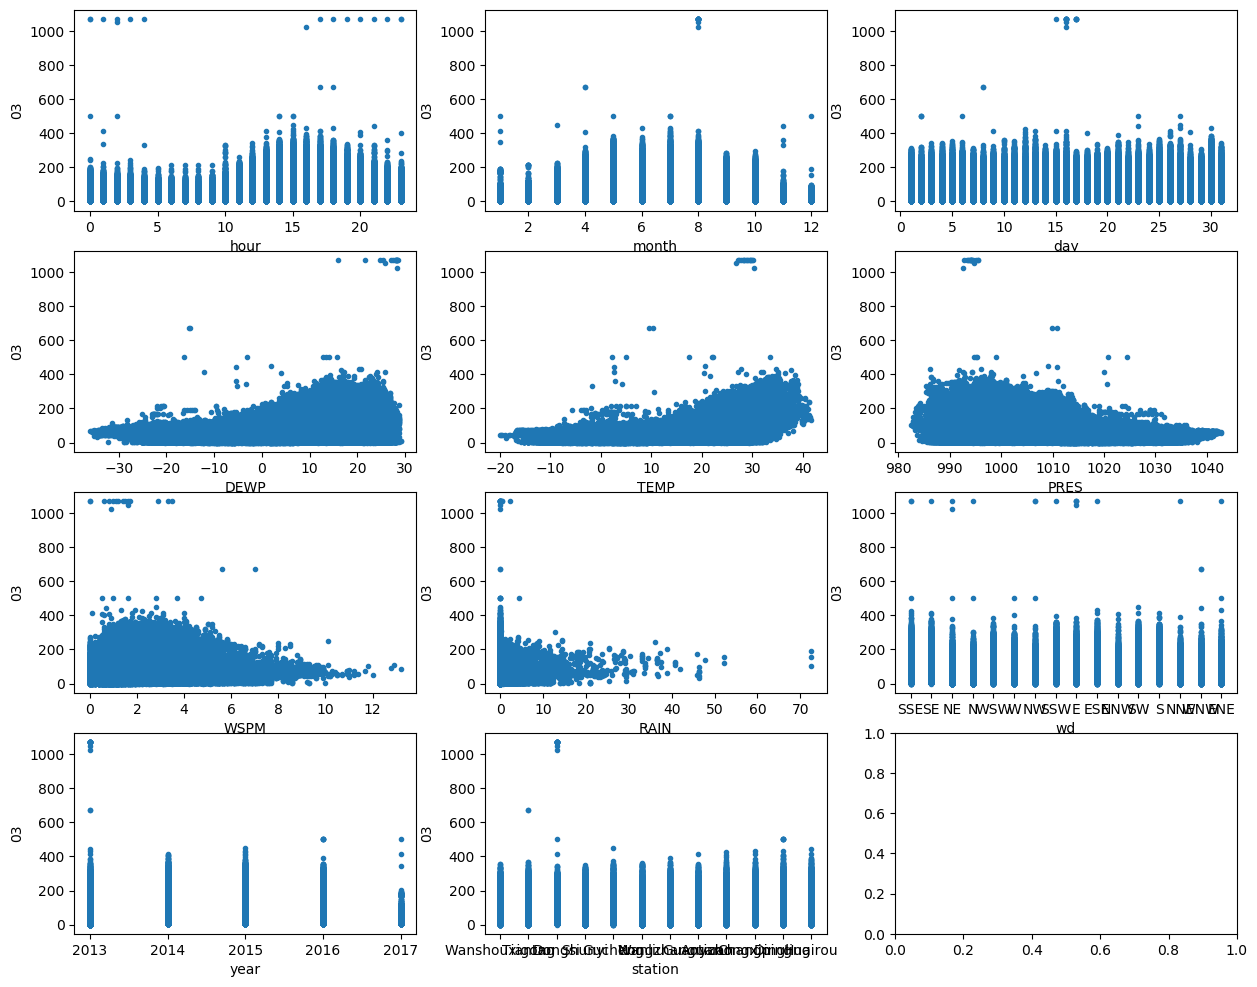

In [92]:
# plots scatter graph with the mean value of the target for each value of the attribute (string imput)
# log is true when we want to plot it with a logarithmic scale

def plotTargetPerAttribute(data, attribute, ax=plt, logx=False, logy=False) :
    if logx :
        ax.semilogx(data[attribute], data["O3"])
    elif logy :
        ax.semilogy(data[attribute], data["O3"])
    else :
        ax.plot(data[attribute], data["O3"], '.')
    ax.set(xlabel=attribute)
    ax.set(ylabel="03")
    #ax.savefig("./max_iter_ppn.pdf")

def plotAllAttributes(data) :
    plt.clf()
    fig, axs = plt.subplots(4,3, figsize = (15,12))
    j = -1
    for i in range(11) :
        attribute = attributes[i]
        plotTargetPerAttribute(data, attribute, axs[j][i%3])
        if i%3 == 0:
            j += 1
    plt.savefig("../figures/airquality/plot_all_attributes.jpeg")

plotAllAttributes(df)

[279692, 90522, 25931, 8539, 879, 54, 4, 6, 0, 2, 0, 0, 0, 0, 2, 0]


<Figure size 640x480 with 0 Axes>

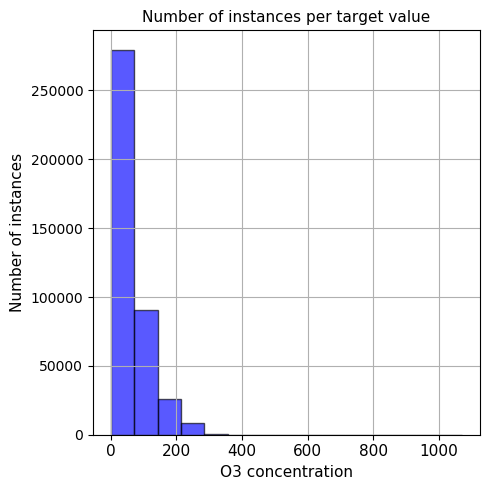

[5.446680044471123, 4.956754140724233, 4.413819265173045, 3.9314070135565733, 2.9439888750737717, 1.7323937598229686, 0.6020599913279624, 0.7781512503836436, 0, 0.3010299956639812, 0, 0, 0, 0, 0.3010299956639812, 0]


<Figure size 640x480 with 0 Axes>

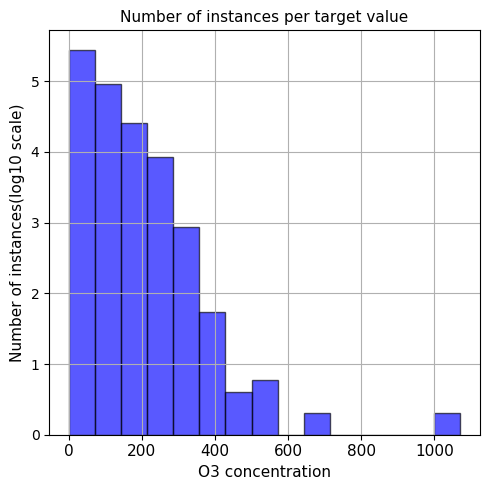

In [93]:
def samplesPerTarget(df, log=False) :
    maxi = df['O3'].max()
    mini = df['O3'].min()
    X = np.arange(mini, maxi+1, (maxi-mini)/15)
    Y = []
    for i in range(len(X)-1):
        if log :
            y = np.log10(df[(df["O3"] >= X[i]) & (df["O3"] < X[i+1])]['O3'].count())
        else :
            y = df[(df["O3"] >= X[i]) & (df["O3"] < X[i+1])]['O3'].count()
        if y >= 0 :
            Y.append(y)
        else :
            Y.append(0)
    Y.append(0)
    print(Y)
    plt.clf()
    plt.figure(figsize=(5,5))
    plt.bar(X,Y,color='blue', align='edge', edgecolor='black', width=[(X[j+1]-X[j]) for j in range(len(X)-1)] + [0], alpha=0.65)
    plt.title("Number of instances per target value",fontsize=11)
    if log :
        plt.ylabel("Number of instances(log10 scale)",fontsize=11)
    else :
        plt.ylabel("Number of instances",fontsize=11)
    plt.xlabel("O3 concentration",fontsize=11)
    plt.xticks(rotation=0,fontsize=11)
    plt.tight_layout()
    plt.grid()
    plt.savefig("../figures/airquality/samples_per_target_value_log="+str(log)+".jpeg")
    plt.show()
samplesPerTarget(df)
samplesPerTarget(df, log=True)

In [94]:
def removeOutliers(df) :
    if 'O3' in df.columns :
        df = df[df['O3'] < 1000]
    return df

from sklearn.preprocessing import MinMaxScaler

# scaling with min-max, useful only for KNN imputation

def scaling(df) :
    num_columns = ["year","month","day","hour","TEMP","PRES","DEWP","RAIN","WSPM"]
    scaler = MinMaxScaler()
    df_num = df[num_columns]
    df_num = pd.DataFrame(scaler.fit_transform(df_num), columns=num_columns)
    for col in num_columns:
        df[col] = df_num[col]
    return df
    
# get the O3 index
indO3 = None

# returns the 5 datasets with the 5 methods of preprocessing

def preprocessing(df) :
    # encode columns by one hot
    df = pd.get_dummies(df, columns=["wd", "station"], prefix=["wd", "stat"])
    wds = [wdname for wdname in df.columns if wdname[:2] == "wd"]
    global indO3
    indO3 = list(df.columns).index('O3')
    removeOutliers(df)
    df = scaling(df)

    df1 = dropRows(df, thres=0, imputation=None)
    df2 = dropRows(df, wds=wds, thres=4, imputation="mean")
    df3 = dropRows(df, wds=wds, thres=(len(df.columns)-1), imputation="mean")
    df4 = dropRows(df, wds=wds, thres=4, imputation="5NN")
    df5 = dropRows(df, wds=wds, thres=(len(df.columns)-1), imputation="5NN")
    DF = [df1,df2,df3,df4,df5]
    for i in range(len(DF)) :
        DF[i] = np.array(DF[i]).astype("float")
    return DF
 
def preprocessing_mean(df) :
    df = pd.get_dummies(df, columns=["wd", "station"], prefix=["wd", "stat"])
    wds = [wdname for wdname in df.columns if wdname[:2] == "wd"]
    global indO3
    indO3 = list(df.columns).index('O3')
    df = dropRows(df, thres=(len(df_origin)-1), imputation="mean")
    df = removeOutliers(df)
    return np.array(df).astype("float")

In [95]:
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import KFold

kf = KFold(n_splits=3, shuffle=True, random_state=42)
split = kf.split(df_origin)
M5regressor_r2_model, const_regressor_r2 = [[] for i in range(5)], [[] for i in range(5)]
M5regressor_MAE_model, const_regressor_MAE = [[] for i in range(5)], [[] for i in range(5)]

# We split the data and apply the pre-processing

for train_index, test_index in split:
        array_train = df_origin.iloc[train_index]
        array_test = df_origin.iloc[test_index]
        
        trains = preprocessing(pd.DataFrame(data=array_train, columns=df_origin.columns))
        tests = preprocessing(pd.DataFrame(data=array_test, columns=df_origin.columns))

        for i in range(5) :
            y_train = trains[i][:,indO3]
            y_test = tests[i][:,indO3]
            X_train = np.delete(trains[i], indO3, axis=1)
            X_test = np.delete(tests[i], indO3, axis=1)
            
            #M5 regressor tree own
            reg = M5regressor(smoothing=True, n_attr_leaf=4, max_depth=4,k=20.0,pruning=True,optimize_models=True,incremental_fit=True).fit(X_train, y_train[:,None])
            M5regressor_r2_model[i].append(r2_score(y_test, reg.predict(X_test)))
            M5regressor_MAE_model[i].append(mean_absolute_error(y_test, reg.predict(X_test)))

            #Constant regressor tree own
            reg2 = Const_regressor(n_attr_leaf = 4, max_depth=8).fit(X_train, y_train[:,None])
            const_regressor_r2[i].append(r2_score(y_test, reg2.predict(X_test)))
            const_regressor_MAE[i].append(mean_absolute_error(y_test, reg2.predict(X_test)))
            
m5_r2, cons_r2 = [], []
for i in range(5):
    m5_r2.append(np.mean(M5regressor_r2_model[i]))
    cons_r2.append(np.mean(const_regressor_r2[i]))

print("m5_r2:", m5_r2)
print("cons_r2:", cons_r2)

calc split of 271375 points
dim, split 6 0.9379310344827585
calc split of 268769 points
dim, split 4 0.241869918699187
calc split of 9697 points
dim, split 8 0.6
calc split of 9664 points
dim, split 6 0.3006896551724137
calc split of 2019 points
dim, split 0 1.0
calc split of 7645 points
dim, split 2 0.03333333333333333
calc split of 33 points
dim, split 3 0.6086956521739131
calc split of 13 points
calc split of 20 points
calc split of 259072 points
dim, split 5 0.8158333333333339
calc split of 256817 points
dim, split 8 0.4083333333333333
calc split of 248732 points
dim, split 3 0.13043478260869565
calc split of 8085 points
dim, split 5 0.33500000000000085
calc split of 2255 points
dim, split 5 0.8966666666666647
calc split of 2217 points
dim, split 5 0.8550000000000004
calc split of 38 points
dim, split 3 0.8695652173913043
calc split of 2606 points
dim, split 4 0.8813008130081301
calc split of 2553 points
dim, split 6 0.9544827586206897
calc split of 1651 points
dim, split 4 0.75447

calc split of 118 points
calc split of 82 points
calc split of 72 points
calc split of 38 points
calc split of 23 points
Make it a leaf backup
calc split of 15 points
Make it a leaf backup
calc split of 34 points
calc split of 10 points
Make it a leaf backup
calc split of 24 points
calc split of 10 points
Make it a leaf backup
calc split of 36 points
calc split of 8 points
Make it a leaf backup
calc split of 28 points
calc split of 18 points
Make it a leaf backup
calc split of 10 points
Make it a leaf backup
calc split of 53 points
calc split of 19 points
Make it a leaf backup
calc split of 34 points
calc split of 27 points
calc split of 8 points
Make it a leaf backup
calc split of 19 points
Make it a leaf backup
calc split of 7 points
Make it a leaf backup
calc split of 271411 points
dim, split 6 0.9379310344827585
calc split of 268805 points
dim, split 4 0.241869918699187
calc split of 9697 points
dim, split 8 0.6
calc split of 9664 points
dim, split 6 0.3006896551724137
calc split o

calc split of 394 points
calc split of 4 points
Make it a leaf backup
calc split of 390 points
calc split of 283 points
calc split of 107 points
calc split of 68 points
calc split of 62 points
calc split of 17 points
Make it a leaf backup
calc split of 45 points
calc split of 6 points
Make it a leaf backup
calc split of 322 points
calc split of 232 points
calc split of 191 points
calc split of 136 points
calc split of 55 points
calc split of 41 points
calc split of 34 points
calc split of 7 points
Make it a leaf backup
calc split of 90 points
calc split of 30 points
calc split of 25 points
calc split of 5 points
Make it a leaf backup
calc split of 60 points
calc split of 18 points
Make it a leaf backup
calc split of 42 points
calc split of 118 points
calc split of 82 points
calc split of 72 points
calc split of 38 points
calc split of 23 points
Make it a leaf backup
calc split of 15 points
Make it a leaf backup
calc split of 34 points
calc split of 10 points
Make it a leaf backup
calc 

calc split of 457 points
calc split of 293 points
calc split of 28 points
calc split of 265 points
calc split of 164 points
calc split of 89 points
calc split of 75 points
calc split of 338 points
calc split of 124 points
calc split of 86 points
calc split of 38 points
calc split of 214 points
calc split of 14 points
Make it a leaf backup
calc split of 200 points
calc split of 902 points
calc split of 784 points
calc split of 462 points
calc split of 394 points
calc split of 4 points
Make it a leaf backup
calc split of 390 points
calc split of 283 points
calc split of 107 points
calc split of 68 points
calc split of 62 points
calc split of 17 points
Make it a leaf backup
calc split of 45 points
calc split of 6 points
Make it a leaf backup
calc split of 322 points
calc split of 232 points
calc split of 191 points
calc split of 136 points
calc split of 55 points
calc split of 41 points
calc split of 34 points
calc split of 7 points
Make it a leaf backup
calc split of 90 points
calc split

calc split of 19 points
Make it a leaf backup
calc split of 61 points
calc split of 37 points
calc split of 18 points
Make it a leaf backup
calc split of 19 points
Make it a leaf backup
calc split of 24 points
calc split of 17 points
Make it a leaf backup
calc split of 7 points
Make it a leaf backup
calc split of 1290 points
calc split of 495 points
calc split of 147 points
calc split of 125 points
calc split of 117 points
calc split of 8 points
Make it a leaf backup
calc split of 22 points
calc split of 6 points
Make it a leaf backup
calc split of 16 points
Make it a leaf backup
calc split of 348 points
calc split of 342 points
calc split of 145 points
calc split of 197 points
calc split of 6 points
Make it a leaf backup
calc split of 795 points
calc split of 457 points
calc split of 293 points
calc split of 28 points
calc split of 265 points
calc split of 164 points
calc split of 89 points
calc split of 75 points
calc split of 338 points
calc split of 124 points
calc split of 86 poin

calc split of 2606 points
calc split of 2553 points
calc split of 1651 points
calc split of 361 points
calc split of 281 points
calc split of 191 points
calc split of 181 points
calc split of 47 points
calc split of 134 points
calc split of 10 points
Make it a leaf backup
calc split of 90 points
calc split of 52 points
calc split of 38 points
calc split of 14 points
Make it a leaf backup
calc split of 38 points
calc split of 7 points
Make it a leaf backup
calc split of 31 points
calc split of 80 points
calc split of 19 points
Make it a leaf backup
calc split of 61 points
calc split of 37 points
calc split of 18 points
Make it a leaf backup
calc split of 19 points
Make it a leaf backup
calc split of 24 points
calc split of 17 points
Make it a leaf backup
calc split of 7 points
Make it a leaf backup
calc split of 1290 points
calc split of 495 points
calc split of 147 points
calc split of 125 points
calc split of 117 points
calc split of 8 points
Make it a leaf backup
calc split of 22 poi

calc split of 16 points
Make it a leaf backup
calc split of 18 points
Make it a leaf backup
calc split of 99 points
calc split of 57 points
calc split of 42 points
calc split of 16 points
Make it a leaf backup
calc split of 18 points
Make it a leaf backup
calc split of 212513 points
calc split of 70121 points
calc split of 3261 points
calc split of 3112 points
calc split of 258 points
calc split of 219 points
calc split of 212 points
calc split of 174 points
calc split of 38 points
calc split of 7 points
Make it a leaf backup
calc split of 39 points
calc split of 31 points
calc split of 8 points
Make it a leaf backup
calc split of 23 points
calc split of 8 points
Make it a leaf backup
calc split of 2854 points
calc split of 1117 points
calc split of 333 points
calc split of 186 points
calc split of 147 points
calc split of 784 points
calc split of 360 points
calc split of 424 points
calc split of 1737 points
calc split of 1722 points
calc split of 45 points
calc split of 1677 points
ca

calc split of 42 points
calc split of 24 points
calc split of 18 points
Make it a leaf backup
calc split of 49787 points
calc split of 959 points
calc split of 887 points
calc split of 854 points
calc split of 520 points
calc split of 507 points
calc split of 13 points
Make it a leaf backup
calc split of 334 points
calc split of 303 points
calc split of 31 points
calc split of 33 points
calc split of 9 points
Make it a leaf backup
calc split of 24 points
calc split of 16 points
Make it a leaf backup
calc split of 8 points
Make it a leaf backup
calc split of 72 points
calc split of 18 points
Make it a leaf backup
calc split of 54 points
calc split of 9 points
Make it a leaf backup
calc split of 45 points
calc split of 27 points
Make it a leaf backup
calc split of 18 points
Make it a leaf backup
calc split of 48828 points
calc split of 796 points
calc split of 663 points
calc split of 571 points
calc split of 546 points
calc split of 25 points
calc split of 92 points
calc split of 69 poi

dim, split 6 0.25154320987654327
calc split of 583 points
dim, split 1 0.7272727272727273
calc split of 565 points
dim, split 2 0.7666666666666667
calc split of 366 points
dim, split 5 0.3394039735099348
calc split of 199 points
dim, split 6 0.9459876543209876
calc split of 18 points
calc split of 212753 points
dim, split 4 0.44098360655737706
calc split of 70121 points
dim, split 3 0.043478260869565216
calc split of 3261 points
dim, split 5 0.8245033112582796
calc split of 3112 points
dim, split 6 0.23302469135802473
calc split of 149 points
dim, split 4 0.260655737704918
calc split of 66860 points
dim, split 7 0.012413793103448275
calc split of 66614 points
dim, split 5 0.7864238410596052
calc split of 246 points
dim, split 5 0.5082781456953676
calc split of 142632 points
dim, split 5 0.4776490066225172
calc split of 105399 points
dim, split 8 0.75
calc split of 105383 points
dim, split 8 0.3106060606060606
calc split of 16 points
calc split of 37233 points
dim, split 3 0.82608695652

calc split of 105399 points
calc split of 105383 points
calc split of 99043 points
calc split of 96715 points
calc split of 74791 points
calc split of 54170 points
calc split of 20621 points
calc split of 21924 points
calc split of 21404 points
calc split of 520 points
calc split of 2328 points
calc split of 308 points
calc split of 262 points
calc split of 46 points
calc split of 2020 points
calc split of 144 points
calc split of 1876 points
calc split of 6340 points
calc split of 1715 points
calc split of 383 points
calc split of 316 points
calc split of 67 points
calc split of 1332 points
calc split of 482 points
calc split of 850 points
calc split of 4625 points
calc split of 94 points
calc split of 19 points
Make it a leaf backup
calc split of 75 points
calc split of 4531 points
calc split of 22 points
calc split of 4509 points
calc split of 16 points
Make it a leaf backup
calc split of 37233 points
calc split of 31077 points
calc split of 31068 points
calc split of 31060 points
c

calc split of 1117 points
calc split of 333 points
calc split of 186 points
calc split of 147 points
calc split of 784 points
calc split of 360 points
calc split of 424 points
calc split of 1737 points
calc split of 1722 points
calc split of 45 points
calc split of 1677 points
calc split of 15 points
Make it a leaf backup
calc split of 149 points
calc split of 100 points
calc split of 51 points
calc split of 8 points
Make it a leaf backup
calc split of 43 points
calc split of 8 points
Make it a leaf backup
calc split of 35 points
calc split of 49 points
calc split of 31 points
calc split of 8 points
Make it a leaf backup
calc split of 23 points
calc split of 18 points
Make it a leaf backup
calc split of 49 points
calc split of 17 points
Make it a leaf backup
calc split of 32 points
calc split of 18 points
Make it a leaf backup
calc split of 14 points
Make it a leaf backup
calc split of 66864 points
calc split of 66618 points
calc split of 60321 points
calc split of 25562 points
calc sp

calc split of 27 points
Make it a leaf backup
calc split of 18 points
Make it a leaf backup
calc split of 48834 points
calc split of 796 points
calc split of 663 points
calc split of 571 points
calc split of 546 points
calc split of 25 points
calc split of 92 points
calc split of 69 points
calc split of 23 points
calc split of 133 points
calc split of 84 points
calc split of 38 points
calc split of 46 points
calc split of 49 points
calc split of 16 points
Make it a leaf backup
calc split of 33 points
calc split of 48038 points
calc split of 35156 points
calc split of 12024 points
calc split of 10972 points
calc split of 1052 points
calc split of 23132 points
calc split of 8121 points
calc split of 15011 points
calc split of 12882 points
calc split of 3907 points
calc split of 410 points
calc split of 3497 points
calc split of 8975 points
calc split of 11 points
Make it a leaf backup
calc split of 8964 points
calc split of 583 points
calc split of 565 points
calc split of 366 points
cal

Make it a leaf backup
calc split of 60 points
calc split of 6 points
Make it a leaf backup
calc split of 54 points
calc split of 10 points
Make it a leaf backup
calc split of 44 points
calc split of 36 points
calc split of 8 points
Make it a leaf backup
calc split of 25 points
calc split of 18 points
calc split of 12 points
Make it a leaf backup
calc split of 6 points
Make it a leaf backup
calc split of 7 points
Make it a leaf backup
calc split of 10 points
Make it a leaf backup
calc split of 271253 points
calc split of 271228 points
calc split of 23244 points
calc split of 2005 points
calc split of 1437 points
calc split of 1132 points
calc split of 1098 points
calc split of 24 points
calc split of 1074 points
calc split of 34 points
calc split of 9 points
Make it a leaf backup
calc split of 25 points
calc split of 305 points
calc split of 281 points
calc split of 65 points
calc split of 216 points
calc split of 24 points
Make it a leaf backup
calc split of 568 points
calc split of 36

calc split of 176 points
calc split of 140 points
calc split of 130 points
calc split of 10 points
Make it a leaf backup
calc split of 132 points
calc split of 41 points
calc split of 32 points
calc split of 9 points
Make it a leaf backup
calc split of 91 points
calc split of 83 points
calc split of 8 points
Make it a leaf backup
calc split of 10982 points
calc split of 1291 points
calc split of 22 points
calc split of 16 points
Make it a leaf backup
calc split of 6 points
Make it a leaf backup
calc split of 1269 points
calc split of 1171 points
calc split of 98 points
calc split of 9691 points
calc split of 995 points
calc split of 268 points
calc split of 727 points
calc split of 8696 points
calc split of 2760 points
calc split of 5936 points
calc split of 224883 points
calc split of 224457 points
calc split of 223425 points
calc split of 46996 points
calc split of 2786 points
calc split of 44210 points
calc split of 176429 points
calc split of 173042 points
calc split of 3387 points

dim, split 5 0.49172185430463955
calc split of 2006 points
dim, split 3 0.6956521739130435
calc split of 21244 points
dim, split 4 0.32218597063621535
calc split of 247984 points
dim, split 5 0.2350993377483448
calc split of 23101 points
dim, split 5 0.19867549668874318
calc split of 224883 points
dim, split 7 0.08275862068965517
calc split of 25 points
dim, split 1 0.2727272727272727
calc split of 9 points
calc split of 16 points
prune left node at level 4
calc split of 271481 points
calc split of 222 points
calc split of 212 points
calc split of 187 points
calc split of 92 points
calc split of 84 points
calc split of 24 points
calc split of 11 points
Make it a leaf backup
calc split of 13 points
Make it a leaf backup
calc split of 60 points
calc split of 12 points
Make it a leaf backup
calc split of 48 points
calc split of 42 points
calc split of 6 points
Make it a leaf backup
calc split of 8 points
Make it a leaf backup
calc split of 95 points
calc split of 35 points
calc split of 8

calc split of 192 points
calc split of 159 points
calc split of 75 points
calc split of 53 points
calc split of 22 points
calc split of 84 points
calc split of 55 points
calc split of 29 points
calc split of 33 points
calc split of 16 points
Make it a leaf backup
calc split of 17 points
calc split of 14 points
calc split of 21090 points
calc split of 14904 points
calc split of 4671 points
calc split of 4013 points
calc split of 658 points
calc split of 10233 points
calc split of 8924 points
calc split of 1309 points
calc split of 6186 points
calc split of 5469 points
calc split of 255 points
calc split of 5214 points
calc split of 717 points
calc split of 707 points
calc split of 10 points
Make it a leaf backup
calc split of 248100 points
calc split of 23101 points
calc split of 12119 points
calc split of 11987 points
calc split of 11847 points
calc split of 11671 points
calc split of 176 points
calc split of 140 points
calc split of 130 points
calc split of 10 points
Make it a leaf ba

# Parameters tuning

We can notice that the difference can be ignored, so in the parameter tuning we will preprocess with the mean value and without deleting any sample.

# Constant regressor tree

calc split of 271661 points
calc split of 222 points
calc split of 212 points
calc split of 187 points
calc split of 92 points
calc split of 95 points
calc split of 25 points
calc split of 18 points
calc split of 7 points
Make it a leaf backup
calc split of 10 points
Make it a leaf backup
calc split of 271439 points
calc split of 271414 points
calc split of 23314 points
calc split of 2032 points
calc split of 21282 points
calc split of 248100 points
calc split of 23101 points
calc split of 224999 points
calc split of 25 points
calc split of 9 points
Make it a leaf backup
calc split of 16 points
Make it a leaf backup
calc split of 271661 points
calc split of 222 points
calc split of 212 points
calc split of 187 points
calc split of 92 points
calc split of 84 points
calc split of 24 points
calc split of 11 points
Make it a leaf backup
calc split of 13 points
Make it a leaf backup
calc split of 60 points
calc split of 12 points
Make it a leaf backup
calc split of 48 points
calc split of 8

calc split of 14904 points
calc split of 4671 points
calc split of 4013 points
calc split of 3860 points
calc split of 228 points
calc split of 3632 points
calc split of 153 points
calc split of 133 points
calc split of 20 points
Make it a leaf backup
calc split of 658 points
calc split of 110 points
calc split of 45 points
calc split of 65 points
calc split of 548 points
calc split of 519 points
calc split of 29 points
calc split of 10233 points
calc split of 8924 points
calc split of 128 points
calc split of 121 points
calc split of 7 points
Make it a leaf backup
calc split of 8796 points
calc split of 67 points
calc split of 8729 points
calc split of 1309 points
calc split of 175 points
calc split of 80 points
calc split of 95 points
calc split of 1134 points
calc split of 55 points
calc split of 1079 points
calc split of 6186 points
calc split of 5469 points
calc split of 255 points
calc split of 30 points
calc split of 14 points
Make it a leaf backup
calc split of 16 points
Make i

calc split of 271414 points
calc split of 23314 points
calc split of 2032 points
calc split of 1461 points
calc split of 1149 points
calc split of 1099 points
calc split of 24 points
calc split of 9 points
Make it a leaf backup
calc split of 15 points
Make it a leaf backup
calc split of 1075 points
calc split of 289 points
calc split of 7 points
Make it a leaf backup
calc split of 282 points
calc split of 146 points
calc split of 7 points
Make it a leaf backup
calc split of 139 points
calc split of 6 points
Make it a leaf backup
calc split of 133 points
calc split of 136 points
calc split of 36 points
calc split of 23 points
calc split of 13 points
Make it a leaf backup
calc split of 100 points
calc split of 37 points
calc split of 63 points
calc split of 786 points
calc split of 23 points
calc split of 13 points
Make it a leaf backup
calc split of 10 points
Make it a leaf backup
calc split of 763 points
calc split of 717 points
calc split of 58 points
calc split of 49 points
calc spli

Make it a leaf backup
calc split of 69 points
calc split of 9 points
Make it a leaf backup
calc split of 60 points
calc split of 29 points
calc split of 19 points
Make it a leaf backup
calc split of 10 points
Make it a leaf backup
calc split of 10233 points
calc split of 8924 points
calc split of 128 points
calc split of 121 points
calc split of 52 points
calc split of 19 points
Make it a leaf backup
calc split of 33 points
calc split of 25 points
Make it a leaf backup
calc split of 8 points
Make it a leaf backup
calc split of 69 points
calc split of 41 points
calc split of 15 points
Make it a leaf backup
calc split of 26 points
calc split of 28 points
calc split of 20 points
Make it a leaf backup
calc split of 8 points
Make it a leaf backup
calc split of 7 points
Make it a leaf backup
calc split of 8796 points
calc split of 67 points
calc split of 46 points
calc split of 14 points
Make it a leaf backup
calc split of 32 points
calc split of 9 points
Make it a leaf backup
calc split of 

calc split of 34 points
calc split of 17 points
Make it a leaf backup
calc split of 17 points
Make it a leaf backup
calc split of 96 points
calc split of 54 points
calc split of 28 points
calc split of 6 points
Make it a leaf backup
calc split of 22 points
calc split of 14 points
Make it a leaf backup
calc split of 8 points
Make it a leaf backup
calc split of 26 points
calc split of 17 points
Make it a leaf backup
calc split of 9 points
Make it a leaf backup
calc split of 42 points
calc split of 8 points
Make it a leaf backup
calc split of 34 points
calc split of 17 points
Make it a leaf backup
calc split of 17 points
Make it a leaf backup
calc split of 10 points
Make it a leaf backup
calc split of 132 points
calc split of 41 points
calc split of 32 points
calc split of 7 points
Make it a leaf backup
calc split of 25 points
calc split of 6 points
Make it a leaf backup
calc split of 19 points
Make it a leaf backup
calc split of 9 points
Make it a leaf backup
calc split of 91 points
calc

calc split of 1208 points
calc split of 954 points
calc split of 254 points
calc split of 867 points
calc split of 408 points
calc split of 459 points
calc split of 79 points
calc split of 41 points
calc split of 27 points
calc split of 14 points
Make it a leaf backup
calc split of 38 points
calc split of 32 points
calc split of 6 points
Make it a leaf backup
calc split of 31 points
calc split of 9 points
Make it a leaf backup
calc split of 22 points
calc split of 16 points
Make it a leaf backup
calc split of 6 points
Make it a leaf backup
calc split of 224999 points
calc split of 224572 points
calc split of 223539 points
calc split of 47000 points
calc split of 2786 points
calc split of 2778 points
calc split of 9 points
Make it a leaf backup
calc split of 2769 points
calc split of 2763 points
calc split of 2689 points
calc split of 2112 points
calc split of 577 points
calc split of 74 points
calc split of 20 points
Make it a leaf backup
calc split of 54 points
calc split of 6 points


Make it a leaf backup
calc split of 65 points
calc split of 20 points
Make it a leaf backup
calc split of 45 points
calc split of 21 points
calc split of 7 points
Make it a leaf backup
calc split of 14 points
Make it a leaf backup
calc split of 24 points
calc split of 7 points
Make it a leaf backup
calc split of 17 points
Make it a leaf backup
calc split of 112 points
calc split of 61 points
calc split of 40 points
calc split of 34 points
calc split of 4 points
Make it a leaf backup
calc split of 30 points
calc split of 20 points
Make it a leaf backup
calc split of 10 points
Make it a leaf backup
calc split of 6 points
Make it a leaf backup
calc split of 21 points
Make it a leaf backup
calc split of 51 points
calc split of 6 points
Make it a leaf backup
calc split of 45 points
calc split of 14 points
Make it a leaf backup
calc split of 31 points
calc split of 22 points
Make it a leaf backup
calc split of 9 points
Make it a leaf backup
calc split of 82 points
calc split of 17 points
Mak

calc split of 5 points
Make it a leaf backup
calc split of 79 points
calc split of 21 points
calc split of 7 points
Make it a leaf backup
calc split of 14 points
Make it a leaf backup
calc split of 58 points
calc split of 48 points
calc split of 13 points
Make it a leaf backup
calc split of 35 points
calc split of 10 points
Make it a leaf backup
calc split of 9 points
Make it a leaf backup
calc split of 109 points
calc split of 19 points
calc split of 6 points
Make it a leaf backup
calc split of 13 points
Make it a leaf backup
calc split of 90 points
calc split of 82 points
calc split of 34 points
calc split of 7 points
Make it a leaf backup
calc split of 27 points
calc split of 17 points
Make it a leaf backup
calc split of 10 points
Make it a leaf backup
calc split of 48 points
calc split of 38 points
calc split of 17 points
Make it a leaf backup
calc split of 21 points
calc split of 10 points
Make it a leaf backup
calc split of 8 points
Make it a leaf backup
calc split of 77 points
c

calc split of 9 points
Make it a leaf backup
calc split of 60 points
calc split of 26 points
calc split of 8 points
Make it a leaf backup
calc split of 18 points
Make it a leaf backup
calc split of 34 points
calc split of 29 points
calc split of 13 points
Make it a leaf backup
calc split of 16 points
Make it a leaf backup
calc split of 5 points
Make it a leaf backup
calc split of 29 points
calc split of 19 points
Make it a leaf backup
calc split of 10 points
Make it a leaf backup
calc split of 10233 points
calc split of 8924 points
calc split of 128 points
calc split of 121 points
calc split of 52 points
calc split of 19 points
Make it a leaf backup
calc split of 33 points
calc split of 25 points
Make it a leaf backup
calc split of 8 points
Make it a leaf backup
calc split of 69 points
calc split of 41 points
calc split of 15 points
Make it a leaf backup
calc split of 26 points
calc split of 16 points
Make it a leaf backup
calc split of 10 points
Make it a leaf backup
calc split of 28 

calc split of 362 points
calc split of 137 points
calc split of 14 points
Make it a leaf backup
calc split of 123 points
calc split of 59 points
calc split of 12 points
Make it a leaf backup
calc split of 47 points
calc split of 27 points
calc split of 12 points
Make it a leaf backup
calc split of 15 points
Make it a leaf backup
calc split of 20 points
calc split of 15 points
Make it a leaf backup
calc split of 5 points
Make it a leaf backup
calc split of 64 points
calc split of 9 points
Make it a leaf backup
calc split of 55 points
calc split of 18 points
Make it a leaf backup
calc split of 37 points
calc split of 26 points
calc split of 11 points
Make it a leaf backup
calc split of 225 points
calc split of 38 points
calc split of 23 points
calc split of 15 points
Make it a leaf backup
calc split of 8 points
Make it a leaf backup
calc split of 15 points
Make it a leaf backup
calc split of 187 points
calc split of 92 points
calc split of 44 points
calc split of 27 points
calc split of 

calc split of 12 points
Make it a leaf backup
calc split of 18 points
Make it a leaf backup
calc split of 20 points
calc split of 10 points
Make it a leaf backup
calc split of 10 points
Make it a leaf backup
calc split of 17 points
Make it a leaf backup
calc split of 114 points
calc split of 86 points
calc split of 22 points
Make it a leaf backup
calc split of 64 points
calc split of 55 points
calc split of 7 points
Make it a leaf backup
calc split of 48 points
calc split of 6 points
Make it a leaf backup
calc split of 42 points
calc split of 9 points
Make it a leaf backup
calc split of 28 points
calc split of 15 points
Make it a leaf backup
calc split of 13 points
Make it a leaf backup
calc split of 10 points
Make it a leaf backup
calc split of 248100 points
calc split of 23101 points
calc split of 12119 points
calc split of 11987 points
calc split of 11847 points
calc split of 11671 points
calc split of 446 points
calc split of 261 points
calc split of 233 points
calc split of 77 poi

calc split of 17 points
Make it a leaf backup
calc split of 17 points
Make it a leaf backup
calc split of 10 points
Make it a leaf backup
calc split of 132 points
calc split of 41 points
calc split of 32 points
calc split of 7 points
Make it a leaf backup
calc split of 25 points
calc split of 6 points
Make it a leaf backup
calc split of 19 points
Make it a leaf backup
calc split of 9 points
Make it a leaf backup
calc split of 91 points
calc split of 83 points
calc split of 41 points
calc split of 32 points
calc split of 23 points
calc split of 15 points
Make it a leaf backup
calc split of 8 points
Make it a leaf backup
calc split of 9 points
Make it a leaf backup
calc split of 9 points
Make it a leaf backup
calc split of 42 points
calc split of 6 points
Make it a leaf backup
calc split of 36 points
calc split of 12 points
Make it a leaf backup
calc split of 24 points
calc split of 16 points
Make it a leaf backup
calc split of 8 points
Make it a leaf backup
calc split of 8 points
Make i

calc split of 18 points
Make it a leaf backup
calc split of 8 points
Make it a leaf backup
calc split of 2185 points
calc split of 2154 points
calc split of 2075 points
calc split of 1208 points
calc split of 954 points
calc split of 474 points
calc split of 402 points
calc split of 358 points
calc split of 44 points
calc split of 72 points
calc split of 8 points
Make it a leaf backup
calc split of 64 points
calc split of 480 points
calc split of 96 points
calc split of 75 points
calc split of 21 points
calc split of 384 points
calc split of 84 points
calc split of 300 points
calc split of 254 points
calc split of 236 points
calc split of 119 points
calc split of 91 points
calc split of 28 points
calc split of 117 points
calc split of 18 points
Make it a leaf backup
calc split of 99 points
calc split of 18 points
Make it a leaf backup
calc split of 867 points
calc split of 408 points
calc split of 324 points
calc split of 60 points
calc split of 39 points
calc split of 21 points
calc s

calc split of 1238 points
calc split of 11641 points
calc split of 11620 points
calc split of 421 points
calc split of 11199 points
calc split of 21 points
calc split of 8 points
Make it a leaf backup
calc split of 13 points
Make it a leaf backup
calc split of 38 points
calc split of 10 points
Make it a leaf backup
calc split of 28 points
calc split of 19 points
Make it a leaf backup
calc split of 9 points
Make it a leaf backup
calc split of 21852 points
calc split of 20691 points
calc split of 482 points
calc split of 42 points
calc split of 16 points
Make it a leaf backup
calc split of 26 points
calc split of 10 points
Make it a leaf backup
calc split of 16 points
Make it a leaf backup
calc split of 440 points
calc split of 281 points
calc split of 233 points
calc split of 216 points
calc split of 32 points
calc split of 184 points
calc split of 17 points
Make it a leaf backup
calc split of 48 points
calc split of 21 points
calc split of 14 points
Make it a leaf backup
calc split of 

calc split of 34804 points
calc split of 1958 points
calc split of 1826 points
calc split of 132 points
calc split of 32846 points
calc split of 8765 points
calc split of 24081 points
calc split of 1138 points
calc split of 1098 points
calc split of 245 points
calc split of 853 points
calc split of 40 points
calc split of 24 points
calc split of 16 points
Make it a leaf backup
calc split of 21245 points
calc split of 15118 points
calc split of 14481 points
calc split of 3379 points
calc split of 3346 points
calc split of 33 points
calc split of 11102 points
calc split of 8893 points
calc split of 2209 points
calc split of 637 points
calc split of 280 points
calc split of 17 points
Make it a leaf backup
calc split of 263 points
calc split of 357 points
calc split of 346 points
calc split of 11 points
Make it a leaf backup
calc split of 6127 points
calc split of 183 points
calc split of 158 points
calc split of 105 points
calc split of 53 points
calc split of 25 points
calc split of 18 p

calc split of 10 points
Make it a leaf backup
calc split of 164 points
calc split of 144 points
calc split of 82 points
calc split of 75 points
calc split of 7 points
Make it a leaf backup
calc split of 62 points
calc split of 19 points
Make it a leaf backup
calc split of 43 points
calc split of 20 points
calc split of 5 points
Make it a leaf backup
calc split of 15 points
Make it a leaf backup
calc split of 14 points
Make it a leaf backup
calc split of 161 points
calc split of 61 points
calc split of 16 points
Make it a leaf backup
calc split of 45 points
calc split of 20 points
calc split of 13 points
Make it a leaf backup
calc split of 7 points
Make it a leaf backup
calc split of 25 points
Make it a leaf backup
calc split of 100 points
calc split of 54 points
calc split of 32 points
calc split of 6 points
Make it a leaf backup
calc split of 26 points
calc split of 21 points
calc split of 16 points
Make it a leaf backup
calc split of 5 points
Make it a leaf backup
calc split of 5 poi

calc split of 17 points
Make it a leaf backup
calc split of 4 points
Make it a leaf backup
calc split of 7 points
Make it a leaf backup
calc split of 15 points
Make it a leaf backup
calc split of 548 points
calc split of 81 points
calc split of 32 points
calc split of 19 points
Make it a leaf backup
calc split of 13 points
Make it a leaf backup
calc split of 49 points
calc split of 25 points
calc split of 9 points
Make it a leaf backup
calc split of 16 points
Make it a leaf backup
calc split of 24 points
calc split of 17 points
Make it a leaf backup
calc split of 7 points
Make it a leaf backup
calc split of 467 points
calc split of 149 points
calc split of 40 points
calc split of 32 points
calc split of 22 points
Make it a leaf backup
calc split of 10 points
Make it a leaf backup
calc split of 8 points
Make it a leaf backup
calc split of 109 points
calc split of 35 points
calc split of 8 points
Make it a leaf backup
calc split of 27 points
calc split of 20 points
calc split of 7 points

calc split of 14904 points
calc split of 4671 points
calc split of 4013 points
calc split of 3860 points
calc split of 228 points
calc split of 26 points
calc split of 18 points
Make it a leaf backup
calc split of 8 points
Make it a leaf backup
calc split of 202 points
calc split of 144 points
calc split of 136 points
calc split of 108 points
calc split of 101 points
calc split of 69 points
calc split of 58 points
calc split of 15 points
Make it a leaf backup
calc split of 43 points
calc split of 35 points
calc split of 8 points
Make it a leaf backup
calc split of 11 points
Make it a leaf backup
calc split of 32 points
calc split of 9 points
Make it a leaf backup
calc split of 23 points
calc split of 15 points
Make it a leaf backup
calc split of 8 points
Make it a leaf backup
calc split of 7 points
Make it a leaf backup
calc split of 28 points
calc split of 10 points
Make it a leaf backup
calc split of 18 points
Make it a leaf backup
calc split of 8 points
Make it a leaf backup
calc sp

Make it a leaf backup
calc split of 27 points
calc split of 11 points
Make it a leaf backup
calc split of 16 points
Make it a leaf backup
calc split of 19 points
Make it a leaf backup
calc split of 17 points
Make it a leaf backup
calc split of 69 points
calc split of 9 points
Make it a leaf backup
calc split of 60 points
calc split of 26 points
calc split of 8 points
Make it a leaf backup
calc split of 18 points
Make it a leaf backup
calc split of 34 points
calc split of 29 points
calc split of 13 points
Make it a leaf backup
calc split of 16 points
Make it a leaf backup
calc split of 5 points
Make it a leaf backup
calc split of 29 points
calc split of 19 points
Make it a leaf backup
calc split of 10 points
Make it a leaf backup
calc split of 10233 points
calc split of 8924 points
calc split of 128 points
calc split of 121 points
calc split of 52 points
calc split of 19 points
Make it a leaf backup
calc split of 33 points
calc split of 25 points
Make it a leaf backup
calc split of 8 po

calc split of 54 points
calc split of 8 points
Make it a leaf backup
calc split of 1483 points
calc split of 1474 points
calc split of 490 points
calc split of 276 points
calc split of 214 points
calc split of 984 points
calc split of 871 points
calc split of 113 points
calc split of 9 points
Make it a leaf backup
calc split of 35 points
calc split of 19 points
Make it a leaf backup
calc split of 16 points
Make it a leaf backup
calc split of 1309 points
calc split of 175 points
calc split of 80 points
calc split of 45 points
calc split of 17 points
Make it a leaf backup
calc split of 28 points
calc split of 9 points
Make it a leaf backup
calc split of 19 points
Make it a leaf backup
calc split of 35 points
calc split of 20 points
Make it a leaf backup
calc split of 15 points
Make it a leaf backup
calc split of 95 points
calc split of 58 points
calc split of 9 points
Make it a leaf backup
calc split of 49 points
calc split of 12 points
Make it a leaf backup
calc split of 37 points
calc 

calc split of 28 points
calc split of 21 points
calc split of 15 points
Make it a leaf backup
calc split of 6 points
Make it a leaf backup
calc split of 7 points
Make it a leaf backup
calc split of 14 points
Make it a leaf backup
calc split of 6 points
Make it a leaf backup
calc split of 95 points
calc split of 66 points
calc split of 32 points
calc split of 18 points
Make it a leaf backup
calc split of 14 points
Make it a leaf backup
calc split of 34 points
calc split of 16 points
Make it a leaf backup
calc split of 18 points
Make it a leaf backup
calc split of 29 points
calc split of 10 points
Make it a leaf backup
calc split of 19 points
Make it a leaf backup
calc split of 1495 points
calc split of 454 points
calc split of 399 points
calc split of 381 points
calc split of 340 points
calc split of 120 points
calc split of 21 points
calc split of 16 points
Make it a leaf backup
calc split of 5 points
Make it a leaf backup
calc split of 99 points
calc split of 39 points
calc split of 2

calc split of 51 points
calc split of 46 points
calc split of 38 points
calc split of 21 points
Make it a leaf backup
calc split of 17 points
Make it a leaf backup
calc split of 8 points
Make it a leaf backup
calc split of 5 points
Make it a leaf backup
calc split of 22 points
calc split of 6 points
Make it a leaf backup
calc split of 16 points
Make it a leaf backup
calc split of 85 points
calc split of 39 points
calc split of 22 points
calc split of 16 points
Make it a leaf backup
calc split of 6 points
Make it a leaf backup
calc split of 17 points
Make it a leaf backup
calc split of 46 points
calc split of 19 points
Make it a leaf backup
calc split of 27 points
calc split of 17 points
Make it a leaf backup
calc split of 10 points
Make it a leaf backup
calc split of 2434 points
calc split of 440 points
calc split of 246 points
calc split of 10 points
Make it a leaf backup
calc split of 236 points
calc split of 164 points
calc split of 121 points
calc split of 86 points
calc split of 6

Make it a leaf backup
calc split of 248100 points
calc split of 23101 points
calc split of 12119 points
calc split of 11987 points
calc split of 11847 points
calc split of 11671 points
calc split of 446 points
calc split of 261 points
calc split of 233 points
calc split of 77 points
calc split of 28 points
calc split of 7 points
Make it a leaf backup
calc split of 21 points
Make it a leaf backup
calc split of 49 points
calc split of 9 points
Make it a leaf backup
calc split of 40 points
calc split of 6 points
Make it a leaf backup
calc split of 34 points
calc split of 25 points
Make it a leaf backup
calc split of 9 points
Make it a leaf backup
calc split of 156 points
calc split of 37 points
calc split of 18 points
Make it a leaf backup
calc split of 19 points
Make it a leaf backup
calc split of 119 points
calc split of 70 points
calc split of 9 points
Make it a leaf backup
calc split of 61 points
calc split of 49 points
calc split of 25 points
Make it a leaf backup
calc split of 24 po

Make it a leaf backup
calc split of 18 points
Make it a leaf backup
calc split of 7409 points
calc split of 4254 points
calc split of 3940 points
calc split of 3650 points
calc split of 3286 points
calc split of 2012 points
calc split of 1996 points
calc split of 1363 points
calc split of 1100 points
calc split of 263 points
calc split of 633 points
calc split of 44 points
calc split of 589 points
calc split of 16 points
Make it a leaf backup
calc split of 1274 points
calc split of 744 points
calc split of 654 points
calc split of 202 points
calc split of 452 points
calc split of 90 points
calc split of 72 points
calc split of 18 points
Make it a leaf backup
calc split of 530 points
calc split of 71 points
calc split of 32 points
calc split of 39 points
calc split of 459 points
calc split of 31 points
calc split of 428 points
calc split of 364 points
calc split of 349 points
calc split of 37 points
calc split of 29 points
calc split of 6 points
Make it a leaf backup
calc split of 23 po

calc split of 83 points
calc split of 41 points
calc split of 32 points
calc split of 23 points
calc split of 15 points
Make it a leaf backup
calc split of 8 points
Make it a leaf backup
calc split of 9 points
Make it a leaf backup
calc split of 9 points
Make it a leaf backup
calc split of 42 points
calc split of 6 points
Make it a leaf backup
calc split of 36 points
calc split of 12 points
Make it a leaf backup
calc split of 24 points
calc split of 16 points
Make it a leaf backup
calc split of 8 points
Make it a leaf backup
calc split of 8 points
Make it a leaf backup
calc split of 10982 points
calc split of 1291 points
calc split of 22 points
calc split of 16 points
Make it a leaf backup
calc split of 6 points
Make it a leaf backup
calc split of 1269 points
calc split of 1171 points
calc split of 991 points
calc split of 754 points
calc split of 301 points
calc split of 281 points
calc split of 234 points
calc split of 26 points
calc split of 9 points
Make it a leaf backup
calc split

Make it a leaf backup
calc split of 7 points
Make it a leaf backup
calc split of 42 points
calc split of 16 points
Make it a leaf backup
calc split of 26 points
calc split of 10 points
Make it a leaf backup
calc split of 16 points
Make it a leaf backup
calc split of 727 points
calc split of 476 points
calc split of 9 points
Make it a leaf backup
calc split of 467 points
calc split of 445 points
calc split of 31 points
calc split of 8 points
Make it a leaf backup
calc split of 23 points
calc split of 16 points
Make it a leaf backup
calc split of 7 points
Make it a leaf backup
calc split of 414 points
calc split of 53 points
calc split of 13 points
Make it a leaf backup
calc split of 40 points
calc split of 13 points
Make it a leaf backup
calc split of 27 points
calc split of 8 points
Make it a leaf backup
calc split of 19 points
Make it a leaf backup
calc split of 361 points
calc split of 329 points
calc split of 197 points
calc split of 190 points
calc split of 76 points
calc split of 

Make it a leaf backup
calc split of 62 points
calc split of 38 points
calc split of 10 points
Make it a leaf backup
calc split of 28 points
calc split of 16 points
Make it a leaf backup
calc split of 12 points
Make it a leaf backup
calc split of 24 points
calc split of 14 points
Make it a leaf backup
calc split of 10 points
Make it a leaf backup
calc split of 321 points
calc split of 17 points
Make it a leaf backup
calc split of 304 points
calc split of 15 points
Make it a leaf backup
calc split of 289 points
calc split of 145 points
calc split of 28 points
calc split of 9 points
Make it a leaf backup
calc split of 19 points
Make it a leaf backup
calc split of 117 points
calc split of 51 points
calc split of 7 points
Make it a leaf backup
calc split of 44 points
calc split of 66 points
calc split of 43 points
calc split of 23 points
calc split of 144 points
calc split of 121 points
calc split of 112 points
calc split of 9 points
Make it a leaf backup
calc split of 103 points
calc split

calc split of 2397 points
calc split of 1520 points
calc split of 1085 points
calc split of 651 points
calc split of 18 points
Make it a leaf backup
calc split of 633 points
calc split of 528 points
calc split of 452 points
calc split of 106 points
calc split of 346 points
calc split of 76 points
calc split of 15 points
Make it a leaf backup
calc split of 61 points
calc split of 105 points
calc split of 45 points
calc split of 29 points
calc split of 16 points
Make it a leaf backup
calc split of 60 points
calc split of 31 points
calc split of 29 points
calc split of 434 points
calc split of 159 points
calc split of 87 points
calc split of 80 points
calc split of 63 points
calc split of 17 points
calc split of 7 points
Make it a leaf backup
calc split of 72 points
calc split of 66 points
calc split of 58 points
calc split of 8 points
Make it a leaf backup
calc split of 6 points
Make it a leaf backup
calc split of 275 points
calc split of 201 points
calc split of 175 points
calc split of

calc split of 69 points
calc split of 33 points
calc split of 9 points
Make it a leaf backup
calc split of 24 points
Make it a leaf backup
calc split of 36 points
calc split of 30 points
calc split of 7 points
Make it a leaf backup
calc split of 23 points
calc split of 6 points
Make it a leaf backup
calc split of 195 points
calc split of 64 points
calc split of 55 points
calc split of 5 points
Make it a leaf backup
calc split of 50 points
calc split of 9 points
Make it a leaf backup
calc split of 131 points
calc split of 79 points
calc split of 73 points
calc split of 6 points
Make it a leaf backup
calc split of 52 points
calc split of 27 points
calc split of 25 points
calc split of 84 points
calc split of 50 points
calc split of 13 points
Make it a leaf backup
calc split of 37 points
calc split of 28 points
calc split of 10 points
Make it a leaf backup
calc split of 18 points
calc split of 11 points
Make it a leaf backup
calc split of 7 points
Make it a leaf backup
calc split of 9 poi

calc split of 50 points
calc split of 45 points
calc split of 5 points
Make it a leaf backup
calc split of 828 points
calc split of 519 points
calc split of 309 points
calc split of 387 points
calc split of 360 points
calc split of 114 points
calc split of 61 points
calc split of 53 points
calc split of 246 points
calc split of 207 points
calc split of 39 points
calc split of 27 points
calc split of 7 points
Make it a leaf backup
calc split of 20 points
calc split of 13 points
Make it a leaf backup
calc split of 7 points
Make it a leaf backup
calc split of 51 points
calc split of 19 points
calc split of 8 points
Make it a leaf backup
calc split of 11 points
Make it a leaf backup
calc split of 32 points
calc split of 25 points
calc split of 17 points
Make it a leaf backup
calc split of 8 points
Make it a leaf backup
calc split of 7 points
Make it a leaf backup
calc split of 4450 points
calc split of 4368 points
calc split of 985 points
calc split of 757 points
calc split of 671 points
c

calc split of 33 points
calc split of 283 points
calc split of 247 points
calc split of 36 points
calc split of 317 points
calc split of 41 points
calc split of 14 points
Make it a leaf backup
calc split of 27 points
calc split of 9 points
Make it a leaf backup
calc split of 18 points
Make it a leaf backup
calc split of 276 points
calc split of 75 points
calc split of 62 points
calc split of 20 points
calc split of 9 points
Make it a leaf backup
calc split of 11 points
Make it a leaf backup
calc split of 42 points
calc split of 16 points
Make it a leaf backup
calc split of 26 points
calc split of 7 points
Make it a leaf backup
calc split of 19 points
Make it a leaf backup
calc split of 13 points
Make it a leaf backup
calc split of 201 points
calc split of 185 points
calc split of 50 points
calc split of 43 points
calc split of 34 points
calc split of 9 points
Make it a leaf backup
calc split of 7 points
Make it a leaf backup
calc split of 135 points
calc split of 4 points
Make it a lea

calc split of 19281 points
calc split of 611 points
calc split of 266 points
calc split of 240 points
calc split of 198 points
calc split of 42 points
calc split of 26 points
calc split of 15 points
Make it a leaf backup
calc split of 11 points
Make it a leaf backup
calc split of 345 points
calc split of 132 points
calc split of 120 points
calc split of 12 points
Make it a leaf backup
calc split of 213 points
calc split of 208 points
calc split of 5 points
Make it a leaf backup
calc split of 18670 points
calc split of 1136 points
calc split of 1054 points
calc split of 672 points
calc split of 382 points
calc split of 82 points
calc split of 65 points
calc split of 17 points
Make it a leaf backup
calc split of 17534 points
calc split of 385 points
calc split of 260 points
calc split of 125 points
calc split of 17149 points
calc split of 16226 points
calc split of 923 points
calc split of 1161 points
calc split of 1150 points
calc split of 888 points
calc split of 22 points
calc split o

calc split of 4 points
Make it a leaf backup
calc split of 44 points
calc split of 31 points
Make it a leaf backup
calc split of 13 points
Make it a leaf backup
calc split of 44 points
calc split of 25 points
calc split of 16 points
Make it a leaf backup
calc split of 9 points
Make it a leaf backup
calc split of 19 points
Make it a leaf backup
calc split of 22 points
calc split of 7 points
Make it a leaf backup
calc split of 15 points
Make it a leaf backup
calc split of 1144 points
calc split of 383 points
calc split of 140 points
calc split of 125 points
calc split of 58 points
calc split of 8 points
Make it a leaf backup
calc split of 50 points
calc split of 43 points
calc split of 7 points
Make it a leaf backup
calc split of 67 points
calc split of 47 points
calc split of 25 points
calc split of 22 points
Make it a leaf backup
calc split of 20 points
calc split of 8 points
Make it a leaf backup
calc split of 12 points
Make it a leaf backup
calc split of 15 points
Make it a leaf back

calc split of 628 points
calc split of 14 points
Make it a leaf backup
calc split of 614 points
calc split of 326 points
calc split of 288 points
calc split of 579 points
calc split of 571 points
calc split of 164 points
calc split of 407 points
calc split of 8 points
Make it a leaf backup
calc split of 116 points
calc split of 108 points
calc split of 51 points
calc split of 25 points
calc split of 26 points
Make it a leaf backup
calc split of 57 points
calc split of 40 points
calc split of 17 points
Make it a leaf backup
calc split of 8 points
Make it a leaf backup
calc split of 2216 points
calc split of 2170 points
calc split of 1601 points
calc split of 1269 points
calc split of 1242 points
calc split of 1121 points
calc split of 1111 points
calc split of 10 points
Make it a leaf backup
calc split of 121 points
calc split of 31 points
calc split of 90 points
calc split of 27 points
calc split of 12 points
Make it a leaf backup
calc split of 15 points
Make it a leaf backup
calc spli

calc split of 59 points
calc split of 113 points
calc split of 166 points
calc split of 13 points
Make it a leaf backup
calc split of 153 points
calc split of 124 points
calc split of 29 points
calc split of 40 points
calc split of 24 points
calc split of 19 points
Make it a leaf backup
calc split of 5 points
Make it a leaf backup
calc split of 16 points
Make it a leaf backup
calc split of 21245 points
calc split of 15118 points
calc split of 14481 points
calc split of 3379 points
calc split of 3346 points
calc split of 3320 points
calc split of 779 points
calc split of 598 points
calc split of 181 points
calc split of 2541 points
calc split of 2165 points
calc split of 376 points
calc split of 26 points
Make it a leaf backup
calc split of 33 points
calc split of 9 points
Make it a leaf backup
calc split of 24 points
calc split of 16 points
Make it a leaf backup
calc split of 8 points
Make it a leaf backup
calc split of 11102 points
calc split of 8893 points
calc split of 6641 points
c

calc split of 1576 points
calc split of 1081 points
calc split of 254 points
calc split of 61 points
calc split of 38 points
calc split of 23 points
calc split of 193 points
calc split of 73 points
calc split of 120 points
calc split of 827 points
calc split of 444 points
calc split of 366 points
calc split of 78 points
calc split of 383 points
calc split of 172 points
calc split of 211 points
calc split of 495 points
calc split of 448 points
calc split of 220 points
calc split of 192 points
calc split of 28 points
calc split of 228 points
calc split of 164 points
calc split of 64 points
calc split of 47 points
calc split of 13 points
Make it a leaf backup
calc split of 34 points
calc split of 13 points
Make it a leaf backup
calc split of 21 points
Make it a leaf backup
calc split of 184 points
calc split of 35 points
calc split of 22 points
Make it a leaf backup
calc split of 13 points
Make it a leaf backup
calc split of 149 points
calc split of 19 points
calc split of 11 points
Make 

calc split of 32 points
calc split of 6 points
Make it a leaf backup
calc split of 26 points
calc split of 21 points
calc split of 16 points
Make it a leaf backup
calc split of 5 points
Make it a leaf backup
calc split of 5 points
Make it a leaf backup
calc split of 22 points
Make it a leaf backup
calc split of 46 points
calc split of 31 points
calc split of 9 points
Make it a leaf backup
calc split of 22 points
Make it a leaf backup
calc split of 15 points
Make it a leaf backup
calc split of 427 points
calc split of 159 points
calc split of 31 points
calc split of 16 points
Make it a leaf backup
calc split of 15 points
Make it a leaf backup
calc split of 128 points
calc split of 8 points
Make it a leaf backup
calc split of 120 points
calc split of 115 points
calc split of 72 points
calc split of 20 points
calc split of 6 points
Make it a leaf backup
calc split of 14 points
Make it a leaf backup
calc split of 52 points
calc split of 16 points
Make it a leaf backup
calc split of 36 poin

calc split of 14 points
Make it a leaf backup
calc split of 6 points
Make it a leaf backup
calc split of 7 points
Make it a leaf backup
calc split of 74 points
calc split of 10 points
Make it a leaf backup
calc split of 64 points
calc split of 9 points
Make it a leaf backup
calc split of 55 points
calc split of 31 points
calc split of 11 points
Make it a leaf backup
calc split of 20 points
calc split of 8 points
Make it a leaf backup
calc split of 12 points
Make it a leaf backup
calc split of 24 points
calc split of 13 points
Make it a leaf backup
calc split of 11 points
Make it a leaf backup
calc split of 318 points
calc split of 203 points
calc split of 5 points
Make it a leaf backup
calc split of 198 points
calc split of 97 points
calc split of 41 points
calc split of 13 points
Make it a leaf backup
calc split of 28 points
Make it a leaf backup
calc split of 56 points
calc split of 31 points
calc split of 22 points
calc split of 11 points
Make it a leaf backup
calc split of 11 point

calc split of 192 points
calc split of 159 points
calc split of 75 points
calc split of 53 points
calc split of 29 points
calc split of 20 points
Make it a leaf backup
calc split of 9 points
Make it a leaf backup
calc split of 24 points
calc split of 8 points
Make it a leaf backup
calc split of 16 points
Make it a leaf backup
calc split of 22 points
calc split of 17 points
Make it a leaf backup
calc split of 5 points
Make it a leaf backup
calc split of 84 points
calc split of 55 points
calc split of 23 points
calc split of 15 points
Make it a leaf backup
calc split of 8 points
Make it a leaf backup
calc split of 32 points
calc split of 25 points
Make it a leaf backup
calc split of 7 points
Make it a leaf backup
calc split of 29 points
calc split of 16 points
Make it a leaf backup
calc split of 13 points
Make it a leaf backup
calc split of 33 points
calc split of 16 points
Make it a leaf backup
calc split of 17 points
calc split of 14 points
calc split of 6 points
Make it a leaf backup


calc split of 1304 points
calc split of 442 points
calc split of 13 points
Make it a leaf backup
calc split of 429 points
calc split of 79 points
calc split of 350 points
calc split of 862 points
calc split of 199 points
calc split of 137 points
calc split of 62 points
calc split of 663 points
calc split of 484 points
calc split of 179 points
calc split of 390 points
calc split of 82 points
calc split of 30 points
calc split of 10 points
Make it a leaf backup
calc split of 20 points
calc split of 13 points
Make it a leaf backup
calc split of 7 points
Make it a leaf backup
calc split of 52 points
calc split of 44 points
calc split of 17 points
Make it a leaf backup
calc split of 27 points
calc split of 8 points
Make it a leaf backup
calc split of 308 points
calc split of 21 points
Make it a leaf backup
calc split of 287 points
calc split of 238 points
calc split of 110 points
calc split of 128 points
calc split of 49 points
calc split of 42 points
calc split of 7 points
Make it a leaf b

calc split of 25 points
Make it a leaf backup
calc split of 25 points
calc split of 16 points
Make it a leaf backup
calc split of 9 points
Make it a leaf backup
calc split of 56 points
calc split of 48 points
calc split of 20 points
calc split of 14 points
Make it a leaf backup
calc split of 6 points
Make it a leaf backup
calc split of 28 points
calc split of 10 points
Make it a leaf backup
calc split of 18 points
Make it a leaf backup
calc split of 8 points
Make it a leaf backup
calc split of 77 points
calc split of 24 points
calc split of 15 points
Make it a leaf backup
calc split of 9 points
Make it a leaf backup
calc split of 53 points
calc split of 11 points
Make it a leaf backup
calc split of 42 points
calc split of 25 points
calc split of 17 points
Make it a leaf backup
calc split of 8 points
Make it a leaf backup
calc split of 17 points
Make it a leaf backup
calc split of 178 points
calc split of 63 points
calc split of 44 points
calc split of 24 points
calc split of 14 points


Make it a leaf backup
calc split of 52 points
calc split of 25 points
Make it a leaf backup
calc split of 27 points
calc split of 9 points
Make it a leaf backup
calc split of 18 points
Make it a leaf backup
calc split of 62 points
calc split of 55 points
calc split of 45 points
calc split of 39 points
calc split of 9 points
Make it a leaf backup
calc split of 30 points
calc split of 6 points
Make it a leaf backup
calc split of 10 points
Make it a leaf backup
calc split of 7 points
Make it a leaf backup
calc split of 61 points
calc split of 25 points
calc split of 7 points
Make it a leaf backup
calc split of 18 points
Make it a leaf backup
calc split of 36 points
calc split of 27 points
calc split of 19 points
Make it a leaf backup
calc split of 8 points
Make it a leaf backup
calc split of 9 points
Make it a leaf backup
calc split of 2888 points
calc split of 1216 points
calc split of 1158 points
calc split of 220 points
calc split of 61 points
calc split of 44 points
calc split of 31 p

calc split of 15 points
Make it a leaf backup
calc split of 10 points
Make it a leaf backup
calc split of 9 points
Make it a leaf backup
calc split of 10 points
Make it a leaf backup
calc split of 12 points
Make it a leaf backup
calc split of 137 points
calc split of 84 points
calc split of 67 points
calc split of 36 points
calc split of 8 points
Make it a leaf backup
calc split of 28 points
calc split of 14 points
Make it a leaf backup
calc split of 14 points
Make it a leaf backup
calc split of 31 points
calc split of 14 points
Make it a leaf backup
calc split of 17 points
Make it a leaf backup
calc split of 17 points
Make it a leaf backup
calc split of 53 points
calc split of 21 points
Make it a leaf backup
calc split of 32 points
calc split of 12 points
Make it a leaf backup
calc split of 20 points
calc split of 13 points
Make it a leaf backup
calc split of 7 points
Make it a leaf backup
calc split of 742 points
calc split of 727 points
calc split of 336 points
calc split of 237 poi

Make it a leaf backup
calc split of 18 points
Make it a leaf backup
calc split of 13 points
Make it a leaf backup
calc split of 220 points
calc split of 165 points
calc split of 53 points
calc split of 7 points
Make it a leaf backup
calc split of 46 points
calc split of 31 points
Make it a leaf backup
calc split of 15 points
Make it a leaf backup
calc split of 112 points
calc split of 50 points
calc split of 17 points
Make it a leaf backup
calc split of 33 points
calc split of 24 points
Make it a leaf backup
calc split of 9 points
Make it a leaf backup
calc split of 62 points
calc split of 6 points
Make it a leaf backup
calc split of 56 points
calc split of 32 points
calc split of 8 points
Make it a leaf backup
calc split of 24 points
calc split of 7 points
Make it a leaf backup
calc split of 17 points
Make it a leaf backup
calc split of 24 points
calc split of 23 points
Make it a leaf backup
calc split of 55 points
calc split of 39 points
calc split of 14 points
Make it a leaf backup


calc split of 97 points
calc split of 62 points
calc split of 16 points
Make it a leaf backup
calc split of 46 points
calc split of 5 points
Make it a leaf backup
calc split of 41 points
calc split of 36 points
calc split of 11 points
Make it a leaf backup
calc split of 25 points
calc split of 5 points
Make it a leaf backup
calc split of 35 points
calc split of 17 points
Make it a leaf backup
calc split of 18 points
Make it a leaf backup
calc split of 109 points
calc split of 23 points
calc split of 13 points
Make it a leaf backup
calc split of 10 points
Make it a leaf backup
calc split of 86 points
calc split of 8 points
Make it a leaf backup
calc split of 78 points
calc split of 52 points
calc split of 38 points
calc split of 5 points
Make it a leaf backup
calc split of 33 points
calc split of 14 points
Make it a leaf backup
calc split of 26 points
calc split of 10 points
Make it a leaf backup
calc split of 16 points
Make it a leaf backup
calc split of 100 points
calc split of 94 poi

Make it a leaf backup
calc split of 554 points
calc split of 268 points
calc split of 210 points
calc split of 89 points
calc split of 11 points
Make it a leaf backup
calc split of 78 points
calc split of 67 points
calc split of 11 points
calc split of 121 points
calc split of 93 points
calc split of 57 points
calc split of 36 points
calc split of 28 points
Make it a leaf backup
calc split of 58 points
calc split of 29 points
calc split of 15 points
Make it a leaf backup
calc split of 14 points
Make it a leaf backup
calc split of 29 points
calc split of 15 points
Make it a leaf backup
calc split of 14 points
Make it a leaf backup
calc split of 286 points
calc split of 68 points
calc split of 14 points
Make it a leaf backup
calc split of 54 points
calc split of 14 points
Make it a leaf backup
calc split of 40 points
calc split of 22 points
Make it a leaf backup
calc split of 18 points
Make it a leaf backup
calc split of 218 points
calc split of 25 points
Make it a leaf backup
calc split

calc split of 5 points
Make it a leaf backup
calc split of 29 points
calc split of 13 points
Make it a leaf backup
calc split of 16 points
Make it a leaf backup
calc split of 234 points
calc split of 217 points
calc split of 58 points
calc split of 50 points
calc split of 14 points
Make it a leaf backup
calc split of 36 points
calc split of 8 points
Make it a leaf backup
calc split of 159 points
calc split of 142 points
calc split of 34 points
calc split of 108 points
calc split of 17 points
Make it a leaf backup
calc split of 17 points
Make it a leaf backup
calc split of 313 points
calc split of 44 points
calc split of 10 points
Make it a leaf backup
calc split of 34 points
calc split of 8 points
Make it a leaf backup
calc split of 26 points
calc split of 7 points
Make it a leaf backup
calc split of 19 points
Make it a leaf backup
calc split of 269 points
calc split of 10 points
Make it a leaf backup
calc split of 259 points
calc split of 18 points
Make it a leaf backup
calc split of 

calc split of 155 points
calc split of 17 points
Make it a leaf backup
calc split of 138 points
calc split of 103 points
calc split of 61 points
calc split of 38 points
calc split of 23 points
calc split of 42 points
calc split of 34 points
calc split of 8 points
Make it a leaf backup
calc split of 35 points
calc split of 10 points
Make it a leaf backup
calc split of 25 points
calc split of 18 points
Make it a leaf backup
calc split of 7 points
Make it a leaf backup
calc split of 7 points
Make it a leaf backup
calc split of 461 points
calc split of 439 points
calc split of 243 points
calc split of 35 points
calc split of 16 points
Make it a leaf backup
calc split of 19 points
calc split of 6 points
Make it a leaf backup
calc split of 13 points
Make it a leaf backup
calc split of 208 points
calc split of 99 points
calc split of 74 points
calc split of 19 points
calc split of 55 points
calc split of 25 points
calc split of 9 points
Make it a leaf backup
calc split of 16 points
Make it a 

Make it a leaf backup
calc split of 144 points
calc split of 92 points
calc split of 35 points
calc split of 27 points
calc split of 8 points
Make it a leaf backup
calc split of 57 points
calc split of 41 points
calc split of 16 points
Make it a leaf backup
calc split of 52 points
calc split of 41 points
calc split of 8 points
Make it a leaf backup
calc split of 33 points
calc split of 11 points
Make it a leaf backup
calc split of 51 points
calc split of 9 points
Make it a leaf backup
calc split of 42 points
calc split of 27 points
calc split of 9 points
Make it a leaf backup
calc split of 18 points
Make it a leaf backup
calc split of 15 points
Make it a leaf backup
calc split of 7 points
Make it a leaf backup
calc split of 7 points
Make it a leaf backup
calc split of 73 points
calc split of 7 points
Make it a leaf backup
calc split of 66 points
calc split of 57 points
calc split of 42 points
calc split of 15 points
Make it a leaf backup
calc split of 27 points
calc split of 18 points


calc split of 162 points
calc split of 32 points
calc split of 130 points
calc split of 49 points
calc split of 7 points
Make it a leaf backup
calc split of 42 points
calc split of 68 points
calc split of 45 points
calc split of 25 points
Make it a leaf backup
calc split of 20 points
Make it a leaf backup
calc split of 23 points
Make it a leaf backup
calc split of 860 points
calc split of 506 points
calc split of 303 points
calc split of 298 points
calc split of 5 points
Make it a leaf backup
calc split of 203 points
calc split of 99 points
calc split of 104 points
calc split of 354 points
calc split of 281 points
calc split of 203 points
calc split of 78 points
calc split of 73 points
calc split of 63 points
calc split of 10 points
Make it a leaf backup
calc split of 156 points
calc split of 8 points
Make it a leaf backup
calc split of 148 points
calc split of 118 points
calc split of 18 points
Make it a leaf backup
calc split of 100 points
calc split of 57 points
calc split of 39 poi

calc split of 40 points
calc split of 22 points
calc split of 14 points
Make it a leaf backup
calc split of 8 points
Make it a leaf backup
calc split of 18 points
Make it a leaf backup
calc split of 28 points
calc split of 19 points
Make it a leaf backup
calc split of 9 points
Make it a leaf backup
calc split of 237 points
calc split of 45 points
calc split of 11 points
Make it a leaf backup
calc split of 34 points
calc split of 7 points
Make it a leaf backup
calc split of 27 points
Make it a leaf backup
calc split of 192 points
calc split of 22 points
calc split of 14 points
Make it a leaf backup
calc split of 8 points
Make it a leaf backup
calc split of 170 points
calc split of 40 points
calc split of 14 points
Make it a leaf backup
calc split of 26 points
calc split of 17 points
Make it a leaf backup
calc split of 9 points
Make it a leaf backup
calc split of 130 points
calc split of 116 points
calc split of 53 points
calc split of 5 points
Make it a leaf backup
calc split of 48 poin

calc split of 2760 points
calc split of 2014 points
calc split of 764 points
calc split of 747 points
calc split of 550 points
calc split of 525 points
calc split of 495 points
calc split of 351 points
calc split of 19 points
Make it a leaf backup
calc split of 332 points
calc split of 9 points
Make it a leaf backup
calc split of 323 points
calc split of 37 points
calc split of 21 points
Make it a leaf backup
calc split of 16 points
Make it a leaf backup
calc split of 286 points
calc split of 11 points
Make it a leaf backup
calc split of 275 points
calc split of 55 points
calc split of 38 points
calc split of 16 points
Make it a leaf backup
calc split of 22 points
Make it a leaf backup
calc split of 17 points
Make it a leaf backup
calc split of 220 points
calc split of 16 points
Make it a leaf backup
calc split of 204 points
calc split of 132 points
calc split of 72 points
calc split of 144 points
calc split of 114 points
calc split of 92 points
calc split of 9 points
Make it a leaf ba

Make it a leaf backup
calc split of 40 points
calc split of 31 points
calc split of 21 points
calc split of 10 points
Make it a leaf backup
calc split of 9 points
Make it a leaf backup
calc split of 9 points
Make it a leaf backup
calc split of 23 points
calc split of 16 points
Make it a leaf backup
calc split of 7 points
Make it a leaf backup
calc split of 746 points
calc split of 634 points
calc split of 569 points
calc split of 321 points
calc split of 267 points
calc split of 46 points
calc split of 16 points
Make it a leaf backup
calc split of 30 points
calc split of 22 points
Make it a leaf backup
calc split of 8 points
Make it a leaf backup
calc split of 221 points
calc split of 144 points
calc split of 123 points
calc split of 100 points
calc split of 60 points
calc split of 16 points
Make it a leaf backup
calc split of 44 points
calc split of 27 points
calc split of 7 points
Make it a leaf backup
calc split of 20 points
Make it a leaf backup
calc split of 17 points
Make it a le

calc split of 40 points
calc split of 14 points
Make it a leaf backup
calc split of 26 points
calc split of 9 points
Make it a leaf backup
calc split of 17 points
Make it a leaf backup
calc split of 59 points
calc split of 51 points
calc split of 17 points
Make it a leaf backup
calc split of 34 points
calc split of 6 points
Make it a leaf backup
calc split of 28 points
calc split of 8 points
Make it a leaf backup
calc split of 7 points
Make it a leaf backup
calc split of 103 points
calc split of 23 points
calc split of 17 points
Make it a leaf backup
calc split of 6 points
Make it a leaf backup
calc split of 80 points
calc split of 34 points
calc split of 9 points
Make it a leaf backup
calc split of 25 points
calc split of 7 points
Make it a leaf backup
calc split of 18 points
Make it a leaf backup
calc split of 46 points
calc split of 41 points
calc split of 33 points
calc split of 18 points
Make it a leaf backup
calc split of 15 points
Make it a leaf backup
calc split of 8 points
Mak

calc split of 630 points
calc split of 82 points
calc split of 27 points
calc split of 19 points
Make it a leaf backup
calc split of 8 points
Make it a leaf backup
calc split of 55 points
calc split of 40 points
calc split of 33 points
Make it a leaf backup
calc split of 7 points
Make it a leaf backup
calc split of 15 points
Make it a leaf backup
calc split of 548 points
calc split of 87 points
calc split of 24 points
calc split of 15 points
Make it a leaf backup
calc split of 9 points
Make it a leaf backup
calc split of 63 points
calc split of 50 points
calc split of 19 points
Make it a leaf backup
calc split of 31 points
calc split of 10 points
Make it a leaf backup
calc split of 21 points
calc split of 13 points
Make it a leaf backup
calc split of 461 points
calc split of 296 points
calc split of 174 points
calc split of 166 points
calc split of 54 points
calc split of 112 points
calc split of 8 points
Make it a leaf backup
calc split of 122 points
calc split of 36 points
calc split

calc split of 39 points
calc split of 32 points
calc split of 24 points
calc split of 8 points
Make it a leaf backup
calc split of 16 points
Make it a leaf backup
calc split of 8 points
Make it a leaf backup
calc split of 7 points
Make it a leaf backup
calc split of 21 points
calc split of 5 points
Make it a leaf backup
calc split of 16 points
Make it a leaf backup
calc split of 264 points
calc split of 69 points
calc split of 33 points
calc split of 9 points
Make it a leaf backup
calc split of 24 points
Make it a leaf backup
calc split of 36 points
calc split of 30 points
calc split of 7 points
Make it a leaf backup
calc split of 23 points
calc split of 17 points
Make it a leaf backup
calc split of 6 points
Make it a leaf backup
calc split of 6 points
Make it a leaf backup
calc split of 195 points
calc split of 64 points
calc split of 55 points
calc split of 5 points
Make it a leaf backup
calc split of 50 points
calc split of 12 points
Make it a leaf backup
calc split of 38 points
cal

Make it a leaf backup
calc split of 69 points
calc split of 23 points
calc split of 9 points
Make it a leaf backup
calc split of 14 points
Make it a leaf backup
calc split of 46 points
calc split of 22 points
calc split of 6 points
Make it a leaf backup
calc split of 16 points
Make it a leaf backup
calc split of 24 points
calc split of 17 points
Make it a leaf backup
calc split of 7 points
Make it a leaf backup
calc split of 9 points
Make it a leaf backup
calc split of 1426 points
calc split of 1178 points
calc split of 1123 points
calc split of 1001 points
calc split of 813 points
calc split of 415 points
calc split of 107 points
calc split of 19 points
calc split of 88 points
calc split of 308 points
calc split of 281 points
calc split of 27 points
calc split of 398 points
calc split of 111 points
calc split of 70 points
calc split of 41 points
calc split of 287 points
calc split of 279 points
calc split of 8 points
Make it a leaf backup
calc split of 188 points
calc split of 170 poi

calc split of 42 points
calc split of 22 points
calc split of 198 points
calc split of 17 points
Make it a leaf backup
calc split of 181 points
calc split of 161 points
calc split of 20 points
calc split of 387 points
calc split of 360 points
calc split of 114 points
calc split of 61 points
calc split of 11 points
Make it a leaf backup
calc split of 50 points
calc split of 7 points
Make it a leaf backup
calc split of 43 points
calc split of 28 points
calc split of 15 points
Make it a leaf backup
calc split of 53 points
calc split of 7 points
Make it a leaf backup
calc split of 46 points
calc split of 22 points
calc split of 6 points
Make it a leaf backup
calc split of 16 points
Make it a leaf backup
calc split of 24 points
calc split of 10 points
Make it a leaf backup
calc split of 14 points
Make it a leaf backup
calc split of 246 points
calc split of 207 points
calc split of 91 points
calc split of 21 points
calc split of 15 points
Make it a leaf backup
calc split of 6 points
Make it 

calc split of 46 points
calc split of 7 points
Make it a leaf backup
calc split of 39 points
calc split of 33 points
calc split of 9 points
Make it a leaf backup
calc split of 24 points
Make it a leaf backup
calc split of 6 points
Make it a leaf backup
calc split of 7 points
Make it a leaf backup
calc split of 16 points
Make it a leaf backup
calc split of 276 points
calc split of 176 points
calc split of 145 points
calc split of 63 points
calc split of 35 points
calc split of 18 points
Make it a leaf backup
calc split of 17 points
Make it a leaf backup
calc split of 28 points
calc split of 10 points
Make it a leaf backup
calc split of 18 points
calc split of 11 points
Make it a leaf backup
calc split of 7 points
Make it a leaf backup
calc split of 82 points
calc split of 8 points
Make it a leaf backup
calc split of 74 points
calc split of 33 points
calc split of 9 points
Make it a leaf backup
calc split of 24 points
calc split of 9 points
Make it a leaf backup
calc split of 15 points
M

Make it a leaf backup
calc split of 44 points
calc split of 20 points
Make it a leaf backup
calc split of 24 points
Make it a leaf backup
calc split of 33 points
calc split of 16 points
Make it a leaf backup
calc split of 17 points
Make it a leaf backup
calc split of 283 points
calc split of 247 points
calc split of 36 points
calc split of 10 points
Make it a leaf backup
calc split of 26 points
Make it a leaf backup
calc split of 211 points
calc split of 90 points
calc split of 68 points
calc split of 22 points
calc split of 121 points
calc split of 74 points
calc split of 47 points
calc split of 36 points
calc split of 10 points
Make it a leaf backup
calc split of 26 points
calc split of 16 points
Make it a leaf backup
calc split of 10 points
Make it a leaf backup
calc split of 317 points
calc split of 41 points
calc split of 14 points
Make it a leaf backup
calc split of 27 points
calc split of 9 points
Make it a leaf backup
calc split of 18 points
Make it a leaf backup
calc split of 

calc split of 546 points
calc split of 543 points
calc split of 51 points
calc split of 8 points
Make it a leaf backup
calc split of 43 points
calc split of 492 points
calc split of 225 points
calc split of 267 points
calc split of 1718 points
calc split of 352 points
calc split of 148 points
calc split of 25 points
calc split of 123 points
calc split of 204 points
calc split of 113 points
calc split of 91 points
calc split of 1366 points
calc split of 1339 points
calc split of 1318 points
calc split of 21 points
Make it a leaf backup
calc split of 27 points
calc split of 10 points
Make it a leaf backup
calc split of 17 points
Make it a leaf backup
calc split of 21 points
calc split of 8 points
Make it a leaf backup
calc split of 13 points
Make it a leaf backup
calc split of 38 points
calc split of 10 points
Make it a leaf backup
calc split of 28 points
calc split of 19 points
Make it a leaf backup
calc split of 9 points
Make it a leaf backup
calc split of 21852 points
calc split of 20

calc split of 9 points
Make it a leaf backup
calc split of 15 points
Make it a leaf backup
calc split of 26 points
calc split of 15 points
Make it a leaf backup
calc split of 11 points
Make it a leaf backup
calc split of 345 points
calc split of 132 points
calc split of 120 points
calc split of 31 points
calc split of 15 points
Make it a leaf backup
calc split of 16 points
Make it a leaf backup
calc split of 89 points
calc split of 16 points
Make it a leaf backup
calc split of 73 points
calc split of 45 points
calc split of 28 points
Make it a leaf backup
calc split of 12 points
Make it a leaf backup
calc split of 213 points
calc split of 208 points
calc split of 8 points
Make it a leaf backup
calc split of 200 points
calc split of 193 points
calc split of 157 points
calc split of 36 points
calc split of 7 points
Make it a leaf backup
calc split of 5 points
Make it a leaf backup
calc split of 18670 points
calc split of 1136 points
calc split of 1054 points
calc split of 672 points
calc

calc split of 173152 points
calc split of 172606 points
calc split of 15158 points
calc split of 10461 points
calc split of 709 points
calc split of 82 points
calc split of 8 points
Make it a leaf backup
calc split of 74 points
calc split of 20 points
Make it a leaf backup
calc split of 54 points
calc split of 32 points
calc split of 7 points
Make it a leaf backup
calc split of 25 points
calc split of 16 points
Make it a leaf backup
calc split of 9 points
Make it a leaf backup
calc split of 22 points
calc split of 14 points
Make it a leaf backup
calc split of 8 points
Make it a leaf backup
calc split of 627 points
calc split of 10 points
Make it a leaf backup
calc split of 617 points
calc split of 436 points
calc split of 84 points
calc split of 16 points
Make it a leaf backup
calc split of 68 points
calc split of 49 points
calc split of 15 points
Make it a leaf backup
calc split of 34 points
calc split of 17 points
Make it a leaf backup
calc split of 17 points
Make it a leaf backup
ca

calc split of 27 points
calc split of 12 points
Make it a leaf backup
calc split of 15 points
Make it a leaf backup
calc split of 409 points
calc split of 149 points
calc split of 18 points
Make it a leaf backup
calc split of 131 points
calc split of 90 points
calc split of 41 points
calc split of 260 points
calc split of 89 points
calc split of 22 points
calc split of 67 points
calc split of 171 points
calc split of 164 points
calc split of 7 points
Make it a leaf backup
calc split of 5 points
Make it a leaf backup
calc split of 1708 points
calc split of 1630 points
calc split of 288 points
calc split of 41 points
calc split of 16 points
Make it a leaf backup
calc split of 25 points
calc split of 9 points
Make it a leaf backup
calc split of 16 points
Make it a leaf backup
calc split of 247 points
calc split of 9 points
Make it a leaf backup
calc split of 238 points
calc split of 10 points
Make it a leaf backup
calc split of 228 points
calc split of 176 points
calc split of 52 points
c

Make it a leaf backup
calc split of 27 points
calc split of 22 points
calc split of 6 points
Make it a leaf backup
calc split of 16 points
Make it a leaf backup
calc split of 5 points
Make it a leaf backup
calc split of 3268 points
calc split of 1961 points
calc split of 794 points
calc split of 8 points
Make it a leaf backup
calc split of 786 points
calc split of 659 points
calc split of 178 points
calc split of 24 points
calc split of 15 points
Make it a leaf backup
calc split of 9 points
Make it a leaf backup
calc split of 154 points
calc split of 9 points
Make it a leaf backup
calc split of 145 points
calc split of 49 points
calc split of 41 points
calc split of 8 points
Make it a leaf backup
calc split of 96 points
calc split of 13 points
Make it a leaf backup
calc split of 83 points
calc split of 481 points
calc split of 247 points
calc split of 238 points
calc split of 49 points
calc split of 12 points
Make it a leaf backup
calc split of 37 points
calc split of 189 points
calc s

calc split of 8 points
Make it a leaf backup
calc split of 75 points
calc split of 92 points
calc split of 69 points
calc split of 23 points
calc split of 114 points
calc split of 70 points
calc split of 5 points
Make it a leaf backup
calc split of 65 points
calc split of 44 points
calc split of 28 points
Make it a leaf backup
calc split of 16 points
calc split of 53 points
calc split of 11 points
Make it a leaf backup
calc split of 42 points
calc split of 23 points
Make it a leaf backup
calc split of 19 points
Make it a leaf backup
calc split of 157448 points
calc split of 100209 points
calc split of 93037 points
calc split of 90821 points
calc split of 67069 points
calc split of 28925 points
calc split of 24747 points
calc split of 15911 points
calc split of 13497 points
calc split of 9561 points
calc split of 2131 points
calc split of 1555 points
calc split of 1306 points
calc split of 249 points
calc split of 576 points
calc split of 537 points
calc split of 39 points
calc split of

calc split of 470 points
calc split of 462 points
calc split of 433 points
calc split of 318 points
calc split of 115 points
calc split of 29 points
calc split of 6 points
Make it a leaf backup
calc split of 23 points
calc split of 8 points
Make it a leaf backup
calc split of 516 points
calc split of 211 points
calc split of 32 points
calc split of 25 points
calc split of 7 points
Make it a leaf backup
calc split of 179 points
calc split of 46 points
calc split of 133 points
calc split of 305 points
calc split of 274 points
calc split of 8 points
Make it a leaf backup
calc split of 266 points
calc split of 31 points
calc split of 24 points
Make it a leaf backup
calc split of 7 points
Make it a leaf backup
calc split of 28 points
calc split of 15 points
Make it a leaf backup
calc split of 13 points
Make it a leaf backup
calc split of 1662 points
calc split of 533 points
calc split of 69 points
calc split of 48 points
calc split of 38 points
calc split of 21 points
calc split of 17 point

Make it a leaf backup
calc split of 26 points
Make it a leaf backup
calc split of 57 points
calc split of 40 points
calc split of 35 points
calc split of 28 points
Make it a leaf backup
calc split of 7 points
Make it a leaf backup
calc split of 5 points
Make it a leaf backup
calc split of 17 points
Make it a leaf backup
calc split of 8 points
Make it a leaf backup
calc split of 2216 points
calc split of 2170 points
calc split of 1601 points
calc split of 1269 points
calc split of 1242 points
calc split of 1121 points
calc split of 1111 points
calc split of 1044 points
calc split of 364 points
calc split of 24 points
calc split of 340 points
calc split of 680 points
calc split of 8 points
Make it a leaf backup
calc split of 672 points
calc split of 67 points
calc split of 20 points
Make it a leaf backup
calc split of 47 points
calc split of 20 points
calc split of 27 points
calc split of 10 points
Make it a leaf backup
calc split of 121 points
calc split of 31 points
calc split of 10 po

calc split of 25 points
calc split of 14 points
Make it a leaf backup
calc split of 11 points
Make it a leaf backup
calc split of 44 points
Make it a leaf backup
calc split of 338 points
calc split of 305 points
calc split of 207 points
calc split of 177 points
calc split of 84 points
calc split of 93 points
calc split of 30 points
calc split of 21 points
calc split of 9 points
Make it a leaf backup
calc split of 98 points
calc split of 85 points
calc split of 4 points
Make it a leaf backup
calc split of 81 points
calc split of 13 points
Make it a leaf backup
calc split of 33 points
calc split of 14 points
Make it a leaf backup
calc split of 19 points
Make it a leaf backup
calc split of 25 points
calc split of 17 points
Make it a leaf backup
calc split of 8 points
Make it a leaf backup
calc split of 4591 points
calc split of 2517 points
calc split of 1926 points
calc split of 21 points
Make it a leaf backup
calc split of 1905 points
calc split of 186 points
calc split of 63 points
calc

calc split of 8765 points
calc split of 5936 points
calc split of 3902 points
calc split of 192 points
calc split of 82 points
calc split of 21 points
calc split of 11 points
Make it a leaf backup
calc split of 10 points
Make it a leaf backup
calc split of 61 points
calc split of 29 points
calc split of 32 points
calc split of 110 points
calc split of 93 points
calc split of 61 points
calc split of 32 points
calc split of 17 points
Make it a leaf backup
calc split of 3710 points
calc split of 3059 points
calc split of 3052 points
calc split of 2132 points
calc split of 920 points
calc split of 7 points
Make it a leaf backup
calc split of 651 points
calc split of 49 points
calc split of 19 points
Make it a leaf backup
calc split of 30 points
calc split of 602 points
calc split of 586 points
calc split of 16 points
Make it a leaf backup
calc split of 2034 points
calc split of 303 points
calc split of 152 points
calc split of 37 points
calc split of 20 points
calc split of 17 points
Make 

calc split of 15118 points
calc split of 14481 points
calc split of 3379 points
calc split of 3346 points
calc split of 3320 points
calc split of 779 points
calc split of 598 points
calc split of 389 points
calc split of 339 points
calc split of 104 points
calc split of 235 points
calc split of 50 points
calc split of 37 points
calc split of 13 points
Make it a leaf backup
calc split of 209 points
calc split of 119 points
calc split of 73 points
calc split of 46 points
calc split of 90 points
calc split of 84 points
calc split of 6 points
Make it a leaf backup
calc split of 181 points
calc split of 139 points
calc split of 114 points
calc split of 104 points
calc split of 10 points
Make it a leaf backup
calc split of 25 points
Make it a leaf backup
calc split of 42 points
calc split of 9 points
Make it a leaf backup
calc split of 33 points
calc split of 25 points
calc split of 8 points
Make it a leaf backup
calc split of 2541 points
calc split of 2165 points
calc split of 1828 points
c

calc split of 18 points
Make it a leaf backup
calc split of 25 points
calc split of 17 points
Make it a leaf backup
calc split of 8 points
Make it a leaf backup
calc split of 10 points
Make it a leaf backup
calc split of 11 points
Make it a leaf backup
calc split of 6127 points
calc split of 183 points
calc split of 158 points
calc split of 105 points
calc split of 91 points
calc split of 80 points
calc split of 61 points
calc split of 14 points
Make it a leaf backup
calc split of 47 points
calc split of 40 points
calc split of 33 points
calc split of 7 points
Make it a leaf backup
calc split of 7 points
Make it a leaf backup
calc split of 19 points
Make it a leaf backup
calc split of 11 points
Make it a leaf backup
calc split of 14 points
Make it a leaf backup
calc split of 53 points
calc split of 44 points
calc split of 20 points
Make it a leaf backup
calc split of 24 points
calc split of 6 points
Make it a leaf backup
calc split of 18 points
Make it a leaf backup
calc split of 9 poi

calc split of 84 points
calc split of 74 points
calc split of 8 points
Make it a leaf backup
calc split of 66 points
calc split of 7 points
Make it a leaf backup
calc split of 59 points
calc split of 16 points
Make it a leaf backup
calc split of 43 points
calc split of 24 points
calc split of 17 points
Make it a leaf backup
calc split of 7 points
Make it a leaf backup
calc split of 19 points
Make it a leaf backup
calc split of 10 points
Make it a leaf backup
calc split of 3303 points
calc split of 2102 points
calc split of 2086 points
calc split of 2023 points
calc split of 238 points
calc split of 120 points
calc split of 95 points
calc split of 4 points
Make it a leaf backup
calc split of 91 points
calc split of 10 points
Make it a leaf backup
calc split of 81 points
calc split of 18 points
Make it a leaf backup
calc split of 63 points
calc split of 49 points
calc split of 36 points
calc split of 19 points
Make it a leaf backup
calc split of 17 points
Make it a leaf backup
calc split

Make it a leaf backup
calc split of 15 points
Make it a leaf backup
calc split of 6 points
Make it a leaf backup
calc split of 28 points
Make it a leaf backup
calc split of 14 points
Make it a leaf backup
calc split of 134 points
calc split of 82 points
calc split of 43 points
calc split of 35 points
calc split of 16 points
Make it a leaf backup
calc split of 19 points
calc split of 10 points
Make it a leaf backup
calc split of 9 points
Make it a leaf backup
calc split of 8 points
Make it a leaf backup
calc split of 39 points
calc split of 31 points
calc split of 18 points
Make it a leaf backup
calc split of 13 points
Make it a leaf backup
calc split of 8 points
Make it a leaf backup
calc split of 52 points
calc split of 32 points
calc split of 25 points
calc split of 16 points
calc split of 11 points
Make it a leaf backup
calc split of 5 points
Make it a leaf backup
calc split of 9 points
Make it a leaf backup
calc split of 7 points
Make it a leaf backup
calc split of 20 points
Make i

calc split of 8 points
Make it a leaf backup
calc split of 120 points
calc split of 115 points
calc split of 72 points
calc split of 20 points
calc split of 6 points
Make it a leaf backup
calc split of 14 points
Make it a leaf backup
calc split of 52 points
calc split of 16 points
Make it a leaf backup
calc split of 36 points
calc split of 22 points
calc split of 15 points
Make it a leaf backup
calc split of 7 points
Make it a leaf backup
calc split of 14 points
Make it a leaf backup
calc split of 43 points
calc split of 23 points
Make it a leaf backup
calc split of 20 points
Make it a leaf backup
calc split of 5 points
Make it a leaf backup
calc split of 268 points
calc split of 186 points
calc split of 74 points
calc split of 9 points
Make it a leaf backup
calc split of 65 points
calc split of 20 points
Make it a leaf backup
calc split of 45 points
calc split of 21 points
calc split of 7 points
Make it a leaf backup
calc split of 14 points
Make it a leaf backup
calc split of 24 point

<Figure size 640x480 with 0 Axes>

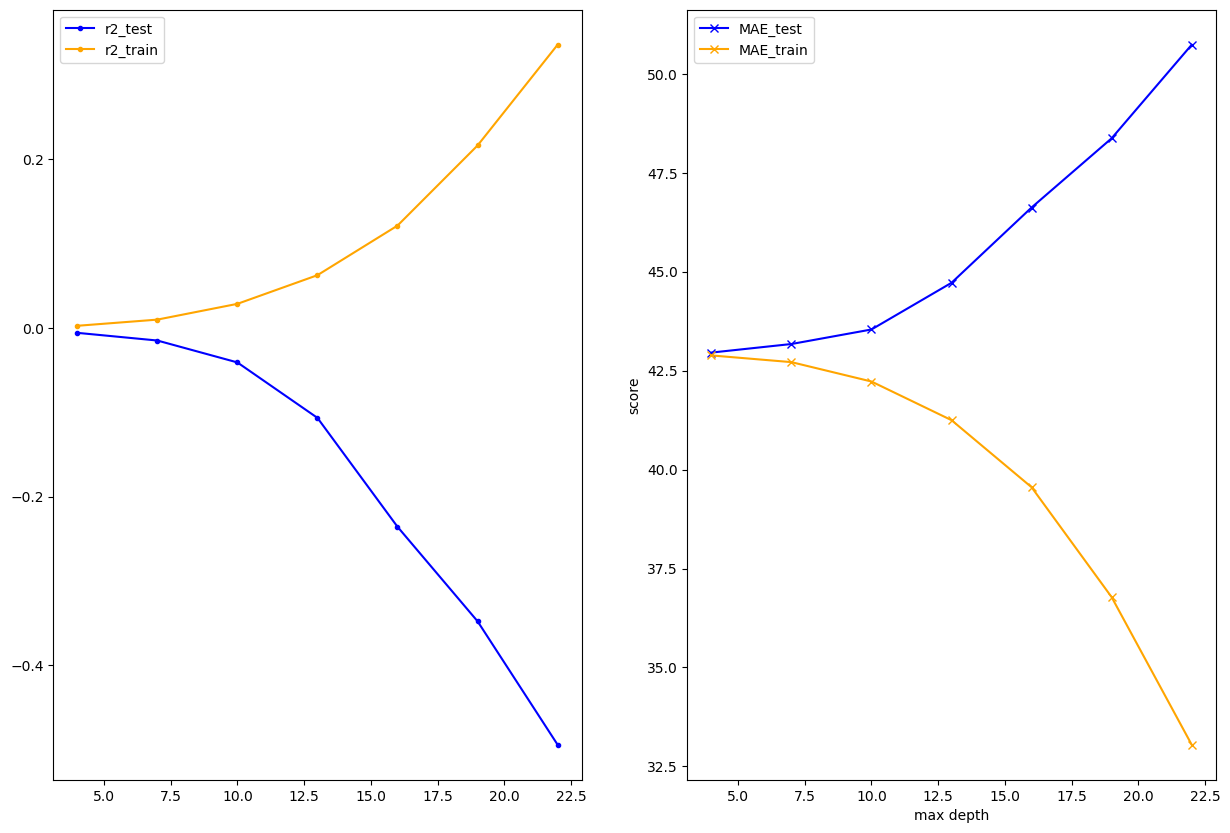

In [98]:
# preprocessing with only mean value
# we use a simple split and just optimize the train part and have a regard to the test part (or validation) in order 
# to avoid overfitting. We do not use grid search because it is too time costly.

train_set, test_set = train_test_split(df_origin, test_size=0.2, random_state=42)
train_set = preprocessing_mean(train_set)
test_set = preprocessing_mean(test_set)
train_target = trains[i][:,indO3]
test_target = tests[i][:,indO3]
train = np.delete(trains[i], indO3, axis=1)
test = np.delete(tests[i], indO3, axis=1)

# maximum depth
vals = np.arange(4,23,3)
r2_test = []
r2_train = []
MAE_test = []
MAE_train = []
for x in vals:
    reg = Const_regressor(n_attr_leaf = 4, max_depth=x).fit(train, train_target[:,None])
    r2_test.append(r2_score(test_target, reg.predict(test)))
    r2_train.append(r2_score(train_target, reg.predict(train)))
    MAE_test.append(mean_absolute_error(test_target, reg.predict(test)))
    MAE_train.append(mean_absolute_error(train_target, reg.predict(train)))
plt.clf()
fig, ax = plt.subplots(1,2, figsize = (15,10))
ax[0].plot(vals, r2_test, marker='.', color="blue", label="r2_test")
ax[0].plot(vals, r2_train, marker='.', color="orange", label="r2_train")
ax[1].plot(vals, MAE_test, marker='x', color="blue", label="MAE_test")
ax[1].plot(vals, MAE_train, marker='x', color="orange", label="MAE_train")
ax[0].legend()
ax[1].legend()
plt.xlabel("max depth")
plt.ylabel("score")
print(r2_test)
plt.savefig("../figures/airquality/max_depth_cons.jpeg")

The optimal depth could be 8 to have a compromise between avoiding overfitting and optimize train score. Now we optimize the number of attributes per leaf.

calc split of 271661 points
calc split of 222 points
calc split of 212 points
calc split of 187 points
calc split of 92 points
calc split of 84 points
calc split of 24 points
calc split of 11 points
Make it a leaf backup
calc split of 13 points
Make it a leaf backup
calc split of 60 points
calc split of 12 points
Make it a leaf backup
calc split of 48 points
calc split of 42 points
calc split of 6 points
Make it a leaf backup
calc split of 8 points
Make it a leaf backup
calc split of 95 points
calc split of 35 points
calc split of 8 points
Make it a leaf backup
calc split of 27 points
calc split of 18 points
Make it a leaf backup
calc split of 9 points
Make it a leaf backup
calc split of 60 points
calc split of 6 points
Make it a leaf backup
calc split of 54 points
calc split of 10 points
Make it a leaf backup
calc split of 44 points
calc split of 36 points
calc split of 8 points
Make it a leaf backup
calc split of 25 points
calc split of 18 points
calc split of 12 points
Make it a lea

calc split of 9691 points
calc split of 995 points
calc split of 268 points
calc split of 727 points
calc split of 8696 points
calc split of 2760 points
calc split of 5936 points
calc split of 224999 points
calc split of 224572 points
calc split of 223539 points
calc split of 47000 points
calc split of 2786 points
calc split of 44214 points
calc split of 176539 points
calc split of 173152 points
calc split of 3387 points
calc split of 1033 points
calc split of 152 points
calc split of 145 points
calc split of 7 points
Make it a leaf backup
calc split of 881 points
calc split of 454 points
calc split of 427 points
calc split of 427 points
calc split of 159 points
calc split of 31 points
calc split of 16 points
Make it a leaf backup
calc split of 15 points
Make it a leaf backup
calc split of 128 points
calc split of 8 points
Make it a leaf backup
calc split of 120 points
calc split of 268 points
calc split of 186 points
calc split of 74 points
calc split of 112 points
calc split of 82 po

calc split of 271439 points
calc split of 271414 points
calc split of 23314 points
calc split of 2032 points
calc split of 1461 points
calc split of 1149 points
calc split of 1099 points
calc split of 1075 points
calc split of 50 points
calc split of 41 points
calc split of 312 points
calc split of 281 points
calc split of 65 points
calc split of 216 points
calc split of 571 points
calc split of 368 points
calc split of 291 points
calc split of 278 points
calc split of 77 points
calc split of 60 points
calc split of 203 points
calc split of 195 points
calc split of 155 points
calc split of 21282 points
calc split of 192 points
calc split of 159 points
calc split of 75 points
calc split of 53 points
calc split of 84 points
calc split of 55 points
calc split of 21090 points
calc split of 14904 points
calc split of 4671 points
calc split of 4013 points
calc split of 658 points
calc split of 10233 points
calc split of 8924 points
calc split of 1309 points
calc split of 6186 points
calc spl

calc split of 271661 points
calc split of 271439 points
calc split of 271414 points
calc split of 23314 points
calc split of 2032 points
calc split of 1461 points
calc split of 1149 points
calc split of 1099 points
calc split of 1075 points
calc split of 571 points
calc split of 21282 points
calc split of 21090 points
calc split of 14904 points
calc split of 4671 points
calc split of 4013 points
calc split of 658 points
calc split of 10233 points
calc split of 8924 points
calc split of 1309 points
calc split of 6186 points
calc split of 5469 points
calc split of 5214 points
calc split of 717 points
calc split of 707 points
calc split of 248100 points
calc split of 23101 points
calc split of 12119 points
calc split of 11987 points
calc split of 11847 points
calc split of 11671 points
calc split of 10982 points
calc split of 1291 points
calc split of 1269 points
calc split of 1171 points
calc split of 9691 points
calc split of 995 points
calc split of 727 points
calc split of 8696 points

<Figure size 640x480 with 0 Axes>

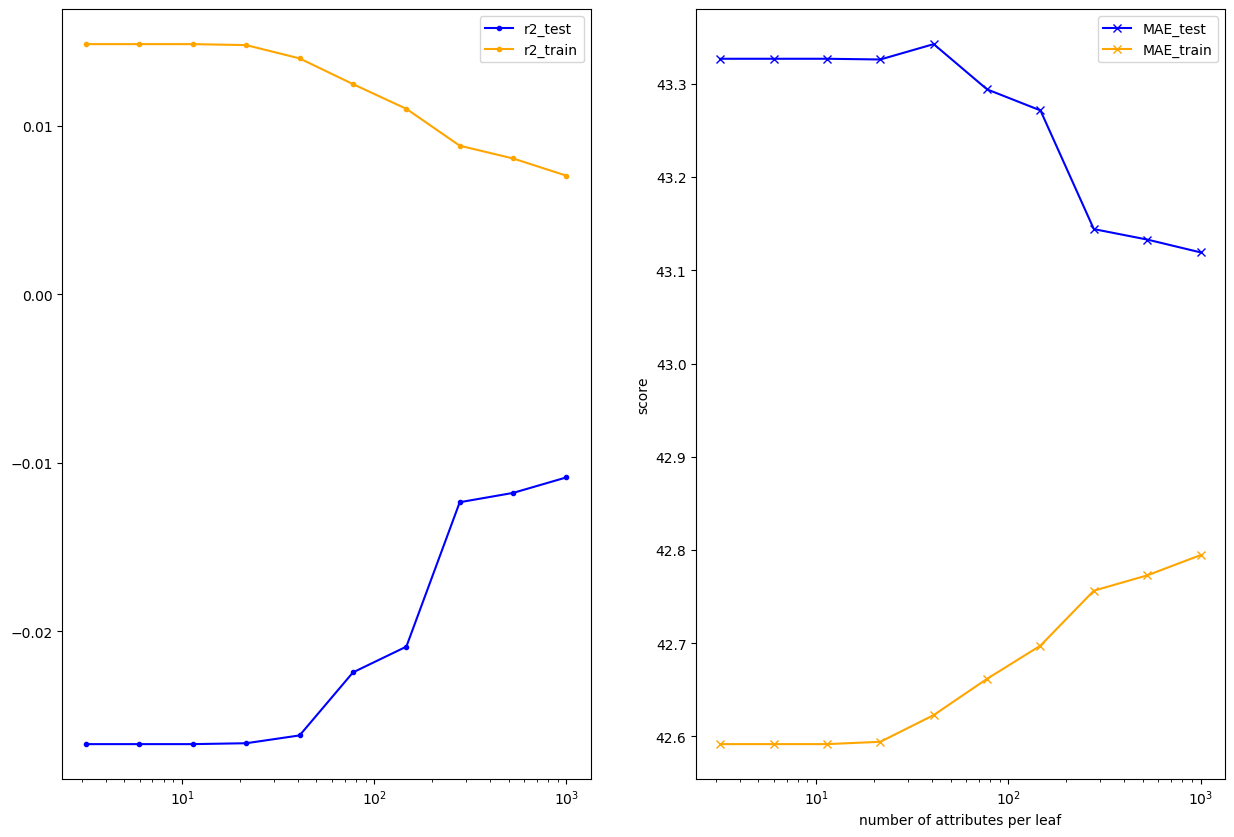

In [99]:
# number of samples per leaf
vals = np.logspace(0.5,3,num=10)
r2_test = []
r2_train = []
MAE_test = []
MAE_train = []
for x in vals:
    reg = Const_regressor(n_attr_leaf = x, max_depth=8).fit(train, train_target[:,None])
    r2_test.append(r2_score(test_target, reg.predict(test)))
    r2_train.append(r2_score(train_target, reg.predict(train)))
    MAE_test.append(mean_absolute_error(test_target, reg.predict(test)))
    MAE_train.append(mean_absolute_error(train_target, reg.predict(train)))
plt.clf()
fig, ax = plt.subplots(1,2, figsize = (15,10))
ax[0].semilogx(vals, r2_test, marker='.', color="blue", label="r2_test")
ax[0].semilogx(vals, r2_train, marker='.', color="orange", label="r2_train")
ax[1].semilogx(vals, MAE_test, marker='x', color="blue", label="MAE_test")
ax[1].semilogx(vals, MAE_train, marker='x', color="orange", label="MAE_train")
ax[0].legend()
ax[1].legend()
plt.xlabel("number of attributes per leaf")
plt.ylabel("score")
print(r2_test)
plt.savefig("../figures/airquality/n_attr_leaf_cons.jpeg")

The optimal number of samples per leaf seems to be 300 to avoid overfitting. We will use these parameters to compare to the other algorithms.

# M5 regressor tree

calc split of 271661 points
dim, split 5 0.06953642384106118
calc split of 222 points
dim, split 1 0.7272727272727273
calc split of 212 points
dim, split 4 0.8858075040783036
calc split of 10 points
calc split of 271439 points
dim, split 8 0.8106060606060606
calc split of 271414 points
dim, split 1 0.09090909090909091
calc split of 25 points
dim, split 1 0.2727272727272727
calc split of 271661 points
dim, split 5 0.06953642384106118
calc split of 222 points
dim, split 1 0.7272727272727273
calc split of 212 points
dim, split 4 0.8858075040783036
calc split of 187 points
dim, split 2 0.4
calc split of 92 points
dim, split 8 0.446969696969697
calc split of 95 points
dim, split 8 0.10606060606060606
calc split of 25 points
dim, split 5 0.06456953642384278
calc split of 18 points
dim, split 5 0.057947019867551575
calc split of 7 points
calc split of 10 points
calc split of 271439 points
dim, split 8 0.8106060606060606
calc split of 271414 points
dim, split 1 0.09090909090909091
calc split o

dim, split 4 0.32218597063621535
calc split of 14904 points
dim, split 3 0.2608695652173913
calc split of 4671 points
dim, split 5 0.7996688741721876
calc split of 4013 points
dim, split 2 0.9666666666666667
calc split of 658 points
dim, split 4 0.17455138662316474
calc split of 10233 points
dim, split 6 0.5006896551724137
calc split of 8924 points
dim, split 8 0.015151515151515152
calc split of 1309 points
dim, split 6 0.5048275862068965
calc split of 6186 points
dim, split 3 0.8695652173913043
calc split of 5469 points
dim, split 6 0.27172413793103445
calc split of 255 points
dim, split 5 0.60430463576159
calc split of 5214 points
dim, split 4 0.3523654159869494
calc split of 717 points
dim, split 8 0.5454545454545455
calc split of 707 points
dim, split 8 0.030303030303030304
calc split of 10 points
calc split of 248100 points
dim, split 5 0.2350993377483448
calc split of 23101 points
dim, split 5 0.19867549668874318
calc split of 12119 points
dim, split 6 0.9668965517241379
calc spl

calc split of 17 points
calc split of 60 points
dim, split 2 0.9666666666666667
calc split of 44 points
dim, split 2 0.23333333333333334
calc split of 8 points
calc split of 36 points
dim, split 3 0.7391304347826086
calc split of 16 points
calc split of 203 points
dim, split 8 0.30303030303030304
calc split of 195 points
dim, split 5 0.4867549668874176
calc split of 155 points
dim, split 8 0.13636363636363638
calc split of 97 points
dim, split 4 0.3703099510603589
calc split of 91 points
dim, split 8 0.09090909090909091
calc split of 6 points
calc split of 58 points
dim, split 4 0.3083197389885807
calc split of 14 points
calc split of 44 points
dim, split 0 0.5
calc split of 40 points
dim, split 3 1.0
calc split of 22 points
dim, split 0 1.0
calc split of 17 points
calc split of 5 points
calc split of 18 points
calc split of 8 points
calc split of 21282 points
dim, split 5 0.5066225165562948
calc split of 192 points
dim, split 4 0.4274061990212072
calc split of 159 points
dim, split 4 

dim, split 3 0.08695652173913043
calc split of 119 points
dim, split 2 0.4
calc split of 107 points
dim, split 6 0.8717241379310344
calc split of 42 points
dim, split 0 0.5
calc split of 16 points
calc split of 26 points
dim, split 4 0.6541598694942904
calc split of 727 points
dim, split 3 0.08695652173913043
calc split of 476 points
dim, split 5 0.20033112582781598
calc split of 9 points
calc split of 467 points
dim, split 8 0.26515151515151514
calc split of 251 points
dim, split 6 0.9020689655172414
calc split of 145 points
dim, split 5 0.2152317880794712
calc split of 106 points
dim, split 5 0.2185430463576168
calc split of 8696 points
dim, split 6 0.8068965517241379
calc split of 2760 points
dim, split 6 0.7889655172413792
calc split of 2014 points
dim, split 6 0.7034482758620689
calc split of 764 points
dim, split 4 0.8694942903752041
calc split of 1250 points
dim, split 6 0.7282758620689654
calc split of 746 points
dim, split 5 0.2317880794701992
calc split of 634 points
dim, spl

calc split of 271439 points
dim, split 8 0.8106060606060606
calc split of 271414 points
dim, split 1 0.09090909090909091
calc split of 23314 points
dim, split 5 0.49172185430463955
calc split of 2032 points
dim, split 3 0.6956521739130435
calc split of 1461 points
dim, split 3 0.5652173913043478
calc split of 1149 points
dim, split 6 0.529655172413793
calc split of 1099 points
dim, split 6 0.36827586206896545
calc split of 24 points
dim, split 3 0.30434782608695654
calc split of 9 points
calc split of 15 points
calc split of 1075 points
dim, split 6 0.41655172413793096
calc split of 289 points
dim, split 5 0.362582781456954
calc split of 7 points
calc split of 282 points
dim, split 5 0.466887417218544
calc split of 146 points
dim, split 8 0.022727272727272728
calc split of 7 points
calc split of 139 points
dim, split 5 0.387417218543046
calc split of 136 points
dim, split 8 0.05303030303030303
calc split of 36 points
dim, split 3 0.2608695652173913
calc split of 100 points
dim, split 5

calc split of 17 points
calc split of 65 points
dim, split 5 0.821192052980134
calc split of 16 points
calc split of 49 points
dim, split 6 0.35586206896551714
calc split of 33 points
dim, split 6 0.20965517241379306
calc split of 16 points
calc split of 548 points
dim, split 6 0.48413793103448266
calc split of 519 points
dim, split 3 0.17391304347826086
calc split of 340 points
dim, split 8 0.34848484848484845
calc split of 315 points
dim, split 8 0.05303030303030303
calc split of 25 points
calc split of 179 points
dim, split 5 0.821192052980134
calc split of 110 points
dim, split 8 0.25
calc split of 69 points
dim, split 5 0.8311258278145708
calc split of 29 points
dim, split 4 0.27732463295269166
calc split of 19 points
calc split of 10 points
calc split of 10233 points
dim, split 6 0.5006896551724137
calc split of 8924 points
dim, split 8 0.015151515151515152
calc split of 128 points
dim, split 6 0.4951724137931034
calc split of 121 points
dim, split 4 0.2642740619902121
calc split

calc split of 48 points
dim, split 4 0.6933115823817293
calc split of 17 points
calc split of 31 points
dim, split 3 0.17391304347826086
calc split of 62 points
dim, split 4 0.7194127243066885
calc split of 47 points
dim, split 3 0.21739130434782608
calc split of 8 points
calc split of 39 points
dim, split 2 0.9
calc split of 15 points
calc split of 59 points
dim, split 5 0.19536423841059758
calc split of 52 points
dim, split 7 0.22758620689655173
calc split of 28 points
dim, split 3 0.9130434782608695
calc split of 11 points
calc split of 17 points
calc split of 24 points
dim, split 2 0.23333333333333334
calc split of 9 points
calc split of 15 points
calc split of 7 points
calc split of 140 points
dim, split 2 0.9999999999999999
calc split of 130 points
dim, split 2 0.13333333333333333
calc split of 34 points
dim, split 4 0.8352365415986951
calc split of 17 points
calc split of 17 points
calc split of 96 points
dim, split 6 0.9586206896551723
calc split of 54 points
dim, split 4 0.796

calc split of 21 points
dim, split 2 0.9666666666666667
calc split of 13 points
calc split of 5936 points
dim, split 2 0.7
calc split of 3751 points
dim, split 3 1.0
calc split of 3556 points
dim, split 2 0.23333333333333334
calc split of 1140 points
dim, split 8 0.17424242424242423
calc split of 967 points
dim, split 3 0.3913043478260869
calc split of 173 points
dim, split 6 0.8317241379310344
calc split of 2416 points
dim, split 6 0.9710344827586206
calc split of 2397 points
dim, split 4 0.7944535073409462
calc split of 19 points
calc split of 195 points
dim, split 6 0.8799999999999999
calc split of 112 points
dim, split 5 0.20695364238410718
calc split of 8 points
calc split of 104 points
dim, split 1 0.6363636363636364
calc split of 83 points
dim, split 4 0.6933115823817293
calc split of 16 points
calc split of 67 points
dim, split 8 0.1590909090909091
calc split of 2185 points
dim, split 8 0.29545454545454547
calc split of 2154 points
dim, split 3 1.0
calc split of 2075 points
dim

dim, split 2 0.9666666666666667
calc split of 32 points
dim, split 4 0.6769983686786297
calc split of 22 points
calc split of 46 points
dim, split 2 0.43333333333333335
calc split of 31 points
dim, split 4 0.6884176182707994
calc split of 15 points
calc split of 427 points
dim, split 2 0.26666666666666666
calc split of 159 points
dim, split 6 0.8317241379310344
calc split of 31 points
dim, split 5 0.62582781456954
calc split of 16 points
calc split of 15 points
calc split of 128 points
dim, split 8 0.07575757575757576
calc split of 8 points
calc split of 120 points
dim, split 6 0.9158620689655171
calc split of 115 points
dim, split 8 0.29545454545454547
calc split of 72 points
dim, split 3 0.3913043478260869
calc split of 20 points
dim, split 3 0.2608695652173913
calc split of 6 points
calc split of 14 points
calc split of 52 points
dim, split 3 0.8260869565217391
calc split of 16 points
calc split of 36 points
dim, split 8 0.17424242424242423
calc split of 43 points
dim, split 8 0.371

dim, split 0 1.0
calc split of 717 points
dim, split 6 0.42068965517241375
calc split of 58 points
dim, split 4 0.4779771615008157
calc split of 49 points
dim, split 4 0.401305057096248
calc split of 40 points
dim, split 8 0.08333333333333334
calc split of 9 points
calc split of 9 points
calc split of 659 points
dim, split 3 0.13043478260869565
calc split of 111 points
dim, split 2 0.1
calc split of 7 points
calc split of 104 points
dim, split 4 0.29853181076672103
calc split of 548 points
dim, split 5 0.42218543046357837
calc split of 81 points
dim, split 5 0.387417218543046
calc split of 467 points
dim, split 5 0.4470198675496704
calc split of 46 points
dim, split 4 0.32218597063621535
calc split of 37 points
dim, split 3 0.30434782608695654
calc split of 14 points
calc split of 23 points
dim, split 3 0.43478260869565216
calc split of 6 points
calc split of 17 points
calc split of 9 points
calc split of 50 points
dim, split 6 0.5324137931034482
calc split of 9 points
calc split of 41

dim, split 4 0.32137030995106036
calc split of 28 points
dim, split 4 0.2561174551386623
calc split of 8 points
calc split of 58 points
dim, split 3 0.21739130434782608
calc split of 34 points
dim, split 2 0.7
calc split of 10 points
calc split of 24 points
dim, split 5 0.7913907284768236
calc split of 24 points
calc split of 3632 points
dim, split 6 0.28965517241379307
calc split of 41 points
dim, split 8 0.28030303030303033
calc split of 32 points
dim, split 3 0.17391304347826086
calc split of 26 points
dim, split 4 0.2814029363784666
calc split of 18 points
calc split of 8 points
calc split of 6 points
calc split of 9 points
calc split of 3591 points
dim, split 6 0.3048275862068965
calc split of 160 points
dim, split 8 0.08333333333333334
calc split of 7 points
calc split of 153 points
dim, split 4 0.21696574225122348
calc split of 67 points
dim, split 5 0.754966887417222
calc split of 86 points
dim, split 3 0.21739130434782608
calc split of 3431 points
dim, split 6 0.31034482758620

dim, split 3 0.43478260869565216
calc split of 391 points
dim, split 4 0.27487765089722677
calc split of 67 points
dim, split 8 0.09090909090909091
calc split of 324 points
dim, split 5 0.5480132450331148
calc split of 15 points
calc split of 6186 points
dim, split 3 0.8695652173913043
calc split of 5469 points
dim, split 6 0.27172413793103445
calc split of 255 points
dim, split 5 0.60430463576159
calc split of 30 points
dim, split 4 0.3980424143556281
calc split of 14 points
calc split of 16 points
calc split of 225 points
dim, split 5 0.6705298013245056
calc split of 53 points
dim, split 2 0.3
calc split of 8 points
calc split of 45 points
dim, split 5 0.6688741721854328
calc split of 37 points
dim, split 0 0.75
calc split of 20 points
calc split of 17 points
calc split of 8 points
calc split of 172 points
dim, split 8 0.25757575757575757
calc split of 151 points
dim, split 4 0.33442088091354
calc split of 71 points
dim, split 8 0.24242424242424243
calc split of 53 points
dim, split 

dim, split 3 0.043478260869565216
calc split of 446 points
dim, split 2 0.4666666666666667
calc split of 261 points
dim, split 5 0.19536423841059758
calc split of 233 points
dim, split 2 0.13333333333333333
calc split of 77 points
dim, split 0 0.25
calc split of 28 points
dim, split 4 0.7243066884176184
calc split of 7 points
calc split of 21 points
calc split of 49 points
dim, split 0 0.5
calc split of 9 points
calc split of 40 points
dim, split 1 0.5454545454545454
calc split of 156 points
dim, split 1 0.4545454545454545
calc split of 37 points
dim, split 5 0.17052980132450557
calc split of 18 points
calc split of 19 points
calc split of 119 points
dim, split 6 0.8868965517241378
calc split of 70 points
dim, split 5 0.1307947019867548
calc split of 49 points
dim, split 5 0.16390728476821437
calc split of 28 points
dim, split 2 0.4
calc split of 19 points
calc split of 9 points
calc split of 185 points
dim, split 6 0.8924137931034481
calc split of 116 points
dim, split 2 0.56666666666

dim, split 5 0.20695364238410718
calc split of 22 points
dim, split 2 0.3333333333333333
calc split of 14 points
calc split of 8 points
calc split of 170 points
dim, split 8 0.08333333333333334
calc split of 40 points
dim, split 3 0.34782608695652173
calc split of 14 points
calc split of 26 points
dim, split 3 0.9565217391304348
calc split of 130 points
dim, split 3 0.7391304347826086
calc split of 116 points
dim, split 6 0.7020689655172413
calc split of 14 points
calc split of 180 points
dim, split 4 0.5872756933115824
calc split of 94 points
dim, split 2 0.26666666666666666
calc split of 47 points
dim, split 3 0.6086956521739131
calc split of 5 points
calc split of 42 points
dim, split 3 0.8260869565217391
calc split of 26 points
calc split of 16 points
calc split of 47 points
dim, split 3 0.043478260869565216
calc split of 13 points
calc split of 34 points
dim, split 2 0.3666666666666667
calc split of 15 points
calc split of 19 points
calc split of 86 points
dim, split 4 0.623164763

dim, split 4 0.8629690048939642
calc split of 37 points
dim, split 3 0.5217391304347826
calc split of 20 points
dim, split 1 0.6363636363636364
calc split of 17 points
calc split of 16 points
calc split of 112 points
dim, split 2 0.6333333333333333
calc split of 78 points
dim, split 8 0.09090909090909091
calc split of 14 points
calc split of 64 points
dim, split 1 0.6363636363636364
calc split of 48 points
dim, split 4 0.6623164763458402
calc split of 6 points
calc split of 42 points
dim, split 0 0.5
calc split of 16 points
calc split of 34 points
dim, split 0 0.5
calc split of 21 points
dim, split 2 0.9666666666666667
calc split of 6 points
calc split of 15 points
calc split of 13 points
calc split of 5936 points
dim, split 2 0.7
calc split of 3751 points
dim, split 3 1.0
calc split of 3556 points
dim, split 2 0.23333333333333334
calc split of 1140 points
dim, split 8 0.17424242424242423
calc split of 967 points
dim, split 3 0.3913043478260869
calc split of 317 points
dim, split 5 0.2

dim, split 5 0.329470198675498
calc split of 20691 points
dim, split 6 0.5241379310344827
calc split of 482 points
dim, split 4 0.6052202283849919
calc split of 42 points
dim, split 4 0.5954323001631322
calc split of 16 points
calc split of 26 points
dim, split 3 0.9130434782608695
calc split of 10 points
calc split of 16 points
calc split of 440 points
dim, split 6 0.49931034482758613
calc split of 281 points
dim, split 3 0.9130434782608695
calc split of 233 points
dim, split 5 0.3261589403973524
calc split of 48 points
dim, split 6 0.46758620689655167
calc split of 159 points
dim, split 3 0.6956521739130435
calc split of 52 points
dim, split 4 0.7422512234910278
calc split of 107 points
dim, split 3 0.7391304347826086
calc split of 20209 points
dim, split 6 0.5282758620689655
calc split of 46 points
dim, split 0 0.75
calc split of 37 points
dim, split 4 0.6590538336052203
calc split of 23 points
calc split of 14 points
calc split of 9 points
calc split of 20163 points
dim, split 1 0.

calc split of 1033 points
dim, split 3 0.17391304347826086
calc split of 152 points
dim, split 1 0.8181818181818182
calc split of 145 points
dim, split 2 0.3
calc split of 75 points
dim, split 7 0.057931034482758624
calc split of 51 points
dim, split 4 0.6411092985318108
calc split of 25 points
dim, split 4 0.6378466557911908
calc split of 21 points
dim, split 5 0.3725165562913908
calc split of 8 points
calc split of 13 points
calc split of 4 points
calc split of 26 points
dim, split 4 0.6508972267536706
calc split of 10 points
calc split of 16 points
calc split of 24 points
dim, split 5 0.346026490066226
calc split of 14 points
calc split of 10 points
calc split of 70 points
dim, split 0 0.25
calc split of 19 points
calc split of 51 points
dim, split 2 0.5
calc split of 9 points
calc split of 42 points
dim, split 8 0.10606060606060606
calc split of 14 points
calc split of 28 points
dim, split 0 0.5
calc split of 8 points
calc split of 20 points
calc split of 7 points
calc split of 881

prune left node at level 14
prune right node at level 13
prune left node at level 14
prune right node at level 14
prune left node at level 13
prune right node at level 13
prune left node at level 13
prune left node at level 13
prune right node at level 14
prune right node at level 14
prune right node at level 14
prune left node at level 14
prune right node at level 12
prune right node at level 13
prune right node at level 14
prune right node at level 11
prune left node at level 11
prune right node at level 12
prune left node at level 11
prune right node at level 11
prune left node at level 9
prune left node at level 11
prune left node at level 10
prune right node at level 9
prune left node at level 11
prune left node at level 14
prune right node at level 14
prune right node at level 13
prune right node at level 14
prune left node at level 12
prune right node at level 14
prune left node at level 14
prune right node at level 12
prune right node at level 10
prune left node at level 11
pru

<Figure size 640x480 with 0 Axes>

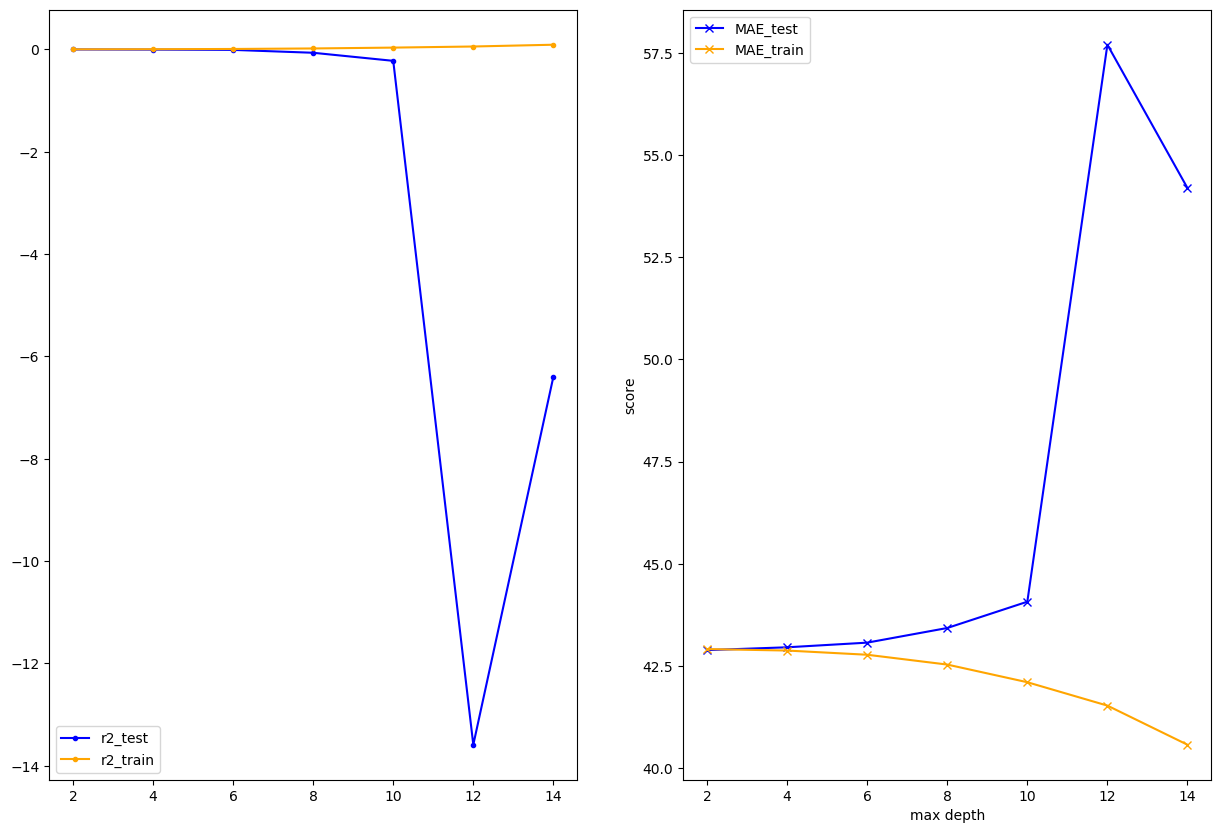

In [100]:
# max depth
vals = np.arange(2,15,2)
r2_test = []
r2_train = []
MAE_test = []
MAE_train = []
for x in vals:
    reg = M5regressor(smoothing=True, n_attr_leaf=4, max_depth=x,k=20.0,pruning=True,optimize_models=True,incremental_fit=True).fit(X_train, y_train[:,None])
    r2_test.append(r2_score(test_target, reg.predict(test)))
    r2_train.append(r2_score(train_target, reg.predict(train)))
    MAE_test.append(mean_absolute_error(test_target, reg.predict(test)))
    MAE_train.append(mean_absolute_error(train_target, reg.predict(train)))
plt.clf()
fig, ax = plt.subplots(1,2, figsize = (15,10))
ax[0].plot(vals, r2_test, marker='.', color="blue", label="r2_test")
ax[0].plot(vals, r2_train, marker='.', color="orange", label="r2_train")
ax[1].plot(vals, MAE_test, marker='x', color="blue", label="MAE_test")
ax[1].plot(vals, MAE_train, marker='x', color="orange", label="MAE_train")
ax[0].legend()
ax[1].legend()
plt.xlabel("max depth")
plt.ylabel("score")
print(r2_test)
plt.savefig("../figures/airquality/max_depth_M5.jpeg")

It seems that the best value is 4 because we overfit after that.

calc split of 271661 points
dim, split 5 0.06953642384106118
calc split of 222 points
dim, split 1 0.7272727272727273
calc split of 212 points
dim, split 4 0.8858075040783036
calc split of 187 points
dim, split 2 0.4
calc split of 92 points
dim, split 8 0.446969696969697
calc split of 95 points
dim, split 8 0.10606060606060606
calc split of 25 points
dim, split 5 0.06456953642384278
calc split of 18 points
dim, split 5 0.057947019867551575
calc split of 7 points
calc split of 10 points
calc split of 271439 points
dim, split 8 0.8106060606060606
calc split of 271414 points
dim, split 1 0.09090909090909091
calc split of 23314 points
dim, split 5 0.49172185430463955
calc split of 2032 points
dim, split 3 0.6956521739130435
calc split of 21282 points
dim, split 5 0.5066225165562948
calc split of 248100 points
dim, split 5 0.2350993377483448
calc split of 23101 points
dim, split 5 0.19867549668874318
calc split of 224999 points
dim, split 7 0.08275862068965517
calc split of 25 points
dim, s

<Figure size 640x480 with 0 Axes>

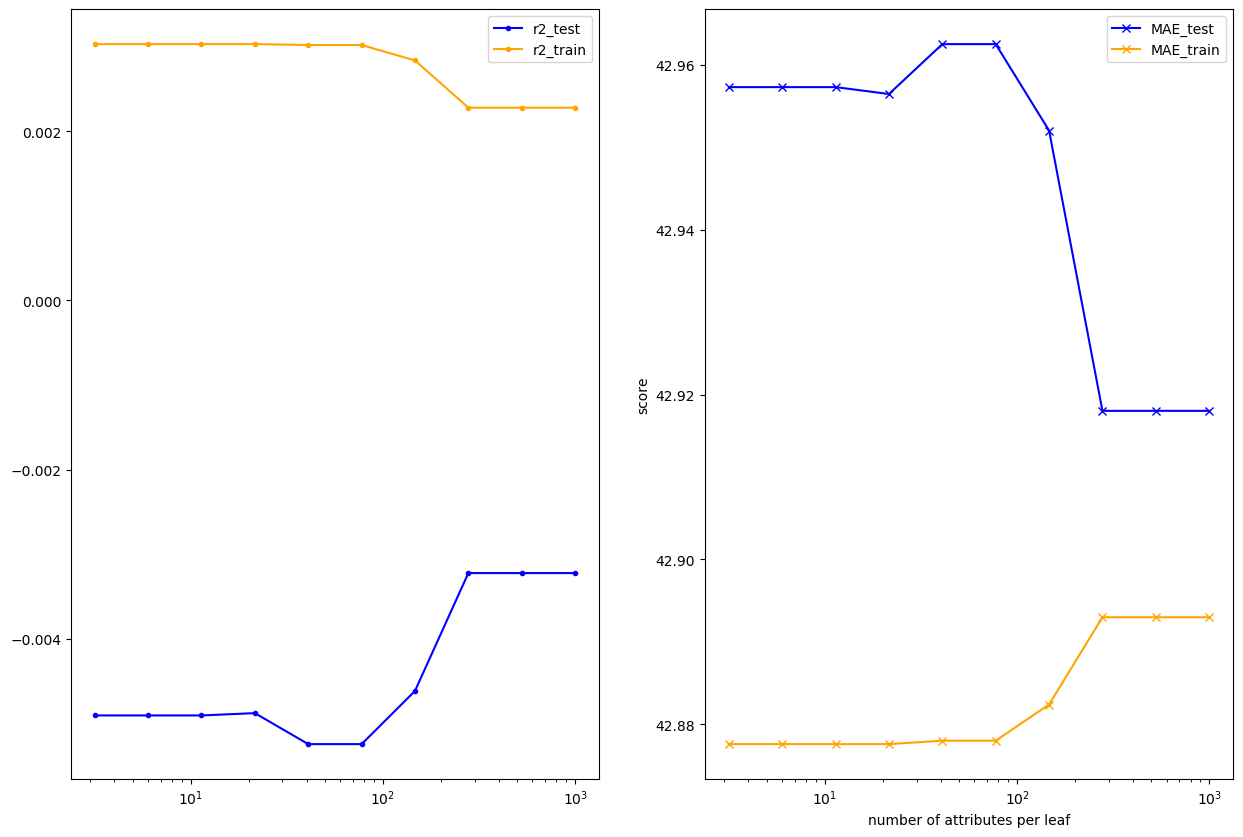

In [101]:
# number of samples per leaf
vals = np.logspace(0.5,3,num=10)
r2_test = []
r2_train = []
MAE_test = []
MAE_train = []
for x in vals:
    reg = M5regressor(smoothing=True, n_attr_leaf=x, max_depth=4,k=20.0,pruning=True,optimize_models=True,incremental_fit=True).fit(X_train, y_train[:,None])
    r2_test.append(r2_score(test_target, reg.predict(test)))
    r2_train.append(r2_score(train_target, reg.predict(train)))
    MAE_test.append(mean_absolute_error(test_target, reg.predict(test)))
    MAE_train.append(mean_absolute_error(train_target, reg.predict(train)))
plt.clf()
fig, ax = plt.subplots(1,2, figsize = (15,10))
ax[0].semilogx(vals, r2_test, marker='.', color="blue", label="r2_test")
ax[0].semilogx(vals, r2_train, marker='.', color="orange", label="r2_train")
ax[1].semilogx(vals, MAE_test, marker='x', color="blue", label="MAE_test")
ax[1].semilogx(vals, MAE_train, marker='x', color="orange", label="MAE_train")
ax[0].legend()
ax[1].legend()
plt.xlabel("number of attributes per leaf")
plt.ylabel("score")
print(r2_test)
plt.savefig("../figures/airquality/n_attr_leaf_M5.jpeg")

500 seems the best

calc split of 271661 points
dim, split 3 0.5652173913043478
calc split of 146475 points
dim, split 2 0.3
calc split of 44445 points
dim, split 4 0.20975609756097563
calc split of 657 points
dim, split 0 0.75
calc split of 439 points
dim, split 3 0.30434782608695654
calc split of 218 points
dim, split 4 0.1869918699186992
calc split of 43788 points
dim, split 4 0.21788617886178863
calc split of 274 points
dim, split 3 0.34782608695652173
calc split of 43514 points
dim, split 5 0.829470198675498
calc split of 102030 points
dim, split 4 0.2894308943089431
calc split of 13934 points
dim, split 6 0.5668965517241379
calc split of 13925 points
dim, split 0 0.25
calc split of 9 points
calc split of 88096 points
dim, split 4 0.2995934959349594
calc split of 2279 points
dim, split 5 0.6390728476821224
calc split of 85817 points
dim, split 6 0.25379310344827577
calc split of 125186 points
dim, split 6 0.9710344827586206
calc split of 125047 points
dim, split 1 0.36363636363636365
calc split of 41

<Figure size 432x288 with 0 Axes>

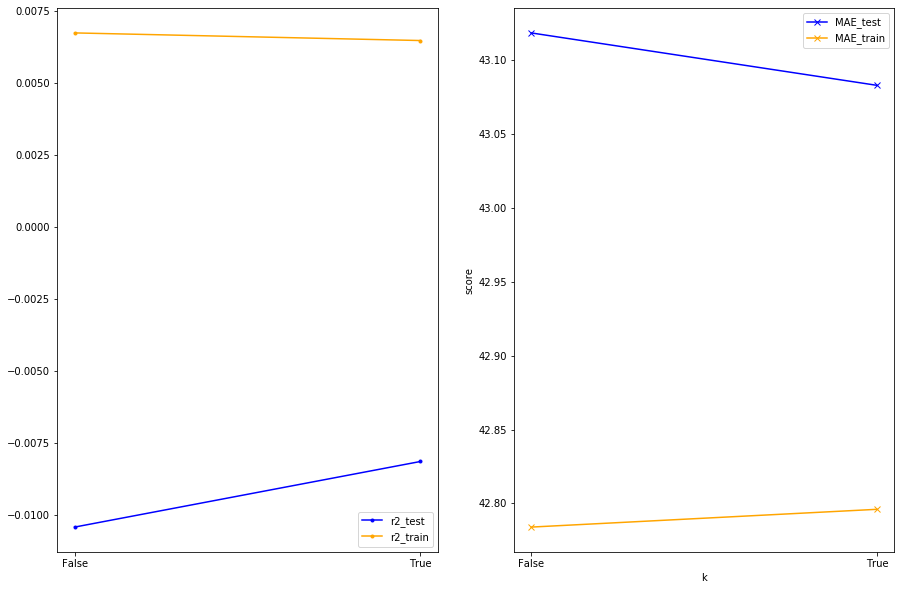

In [17]:
# smoothing
vals = [False,True]
vals_plot=["False","True"]
r2_test = []
r2_train = []
MAE_test = []
MAE_train = []
for x in vals:
    reg = M5regressor(smoothing=x, n_attr_leaf=4, max_depth=4,k=12,pruning=True,optimize_models=True,incremental_fit=True).fit(X_train, y_train[:,None])
    r2_test.append(r2_score(test_target, reg.predict(test)))
    r2_train.append(r2_score(train_target, reg.predict(train)))
    MAE_test.append(mean_absolute_error(test_target, reg.predict(test)))
    MAE_train.append(mean_absolute_error(train_target, reg.predict(train)))
plt.clf()
fig, ax = plt.subplots(1,2, figsize = (15,10))
ax[0].plot(vals_plot, r2_test, marker='.', color="blue", label="r2_test")
ax[0].plot(vals_plot, r2_train, marker='.', color="orange", label="r2_train")
ax[1].plot(vals_plot, MAE_test, marker='x', color="blue", label="MAE_test")
ax[1].plot(vals_plot, MAE_train, marker='x', color="orange", label="MAE_train")
ax[0].legend()
ax[1].legend()
plt.xlabel("k")
plt.ylabel("score")
print(r2_test)
plt.savefig("../figures/airquality/smoothing_M5.jpeg")

We need smoothing to avoid overfitting.

calc split of 271661 points
dim, split 3 0.5652173913043478
calc split of 146475 points
dim, split 2 0.3
calc split of 44445 points
dim, split 4 0.20975609756097563
calc split of 657 points
dim, split 0 0.75
calc split of 439 points
dim, split 3 0.30434782608695654
calc split of 275 points
dim, split 3 0.13043478260869565
calc split of 82 points
dim, split 4 0.1951219512195122
calc split of 193 points
dim, split 6 0.26344827586206887
calc split of 164 points
dim, split 4 0.1934959349593496
calc split of 97 points
dim, split 6 0.37931034482758613
calc split of 67 points
dim, split 8 0.046511627906976744
calc split of 218 points
dim, split 4 0.1869918699186992
calc split of 108 points
dim, split 2 0.13333333333333333
calc split of 47 points
dim, split 4 0.1658536585365854
calc split of 61 points
dim, split 5 0.6076158940397356
calc split of 110 points
dim, split 3 0.34782608695652173
calc split of 103 points
dim, split 2 0.03333333333333333
calc split of 7 points
calc split of 43788 poin

dim, split 6 0.2551724137931034
calc split of 8 points
calc split of 85746 points
dim, split 5 0.7500000000000036
calc split of 125186 points
dim, split 6 0.9710344827586206
calc split of 125047 points
dim, split 1 0.36363636363636365
calc split of 41404 points
dim, split 5 0.796357615894042
calc split of 40045 points
dim, split 7 0.0027586206896551726
calc split of 39553 points
dim, split 2 0.1
calc split of 4093 points
dim, split 6 0.6799999999999999
calc split of 35460 points
dim, split 3 0.9130434782608695
calc split of 492 points
dim, split 4 0.2878048780487805
calc split of 49 points
dim, split 5 0.6539735099337776
calc split of 443 points
dim, split 3 0.6521739130434783
calc split of 1359 points
dim, split 0 0.25
calc split of 22 points
dim, split 4 0.33658536585365856
calc split of 10 points
calc split of 12 points
calc split of 1337 points
dim, split 5 0.9701986754966896
calc split of 1264 points
dim, split 6 0.27862068965517234
calc split of 73 points
dim, split 5 0.976821192

<Figure size 432x288 with 0 Axes>

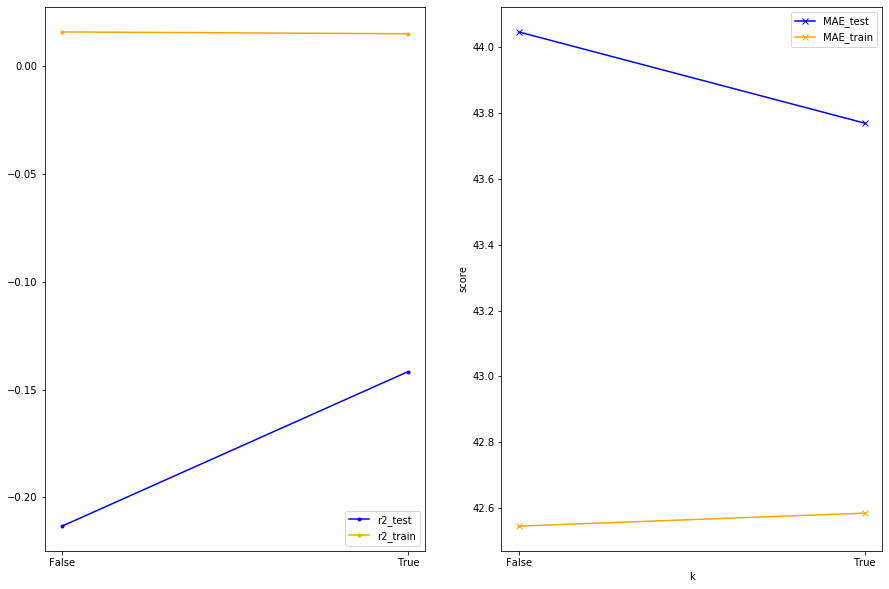

In [18]:
# pruning
vals = [False,True]
vals_plot=["False","True"]
r2_test = []
r2_train = []
MAE_test = []
MAE_train = []
for x in vals:
    reg = M5regressor(smoothing=x, n_attr_leaf=4, max_depth=6,k=12,pruning=True,optimize_models=True,incremental_fit=True).fit(X_train, y_train[:,None])
    r2_test.append(r2_score(test_target, reg.predict(test)))
    r2_train.append(r2_score(train_target, reg.predict(train)))
    MAE_test.append(mean_absolute_error(test_target, reg.predict(test)))
    MAE_train.append(mean_absolute_error(train_target, reg.predict(train)))
plt.clf()
fig, ax = plt.subplots(1,2, figsize = (15,10))
ax[0].plot(vals_plot, r2_test, marker='.', color="blue", label="r2_test")
ax[0].plot(vals_plot, r2_train, marker='.', color="orange", label="r2_train")
ax[1].plot(vals_plot, MAE_test, marker='x', color="blue", label="MAE_test")
ax[1].plot(vals_plot, MAE_train, marker='x', color="orange", label="MAE_train")
ax[0].legend()
ax[1].legend()
plt.xlabel("k")
plt.ylabel("score")
print(r2_test)
plt.savefig("../figures/airquality/pruning_M5.jpeg")

We need pruning to avoid overfitting.

calc split of 271661 points
dim, split 5 0.06953642384106118
calc split of 271439 points
dim, split 8 0.8106060606060606
calc split of 271414 points
dim, split 1 0.09090909090909091
calc split of 23314 points
dim, split 5 0.49172185430463955
calc split of 2032 points
dim, split 3 0.6956521739130435
calc split of 1461 points
dim, split 3 0.5652173913043478
calc split of 1149 points
dim, split 6 0.529655172413793
calc split of 571 points
dim, split 3 0.8695652173913043
calc split of 21282 points
dim, split 5 0.5066225165562948
calc split of 21090 points
dim, split 4 0.32218597063621535
calc split of 14904 points
dim, split 3 0.2608695652173913
calc split of 6186 points
dim, split 3 0.8695652173913043
calc split of 248100 points
dim, split 5 0.2350993377483448
calc split of 23101 points
dim, split 5 0.19867549668874318
calc split of 12119 points
dim, split 6 0.9668965517241379
calc split of 11987 points
dim, split 6 0.9503448275862068
calc split of 10982 points
dim, split 4 0.634584013050

calc split of 223539 points
dim, split 5 0.3344370860927164
calc split of 1033 points
dim, split 3 0.17391304347826086
prune right node at level 0
calc split of 271661 points
dim, split 5 0.06953642384106118
calc split of 271439 points
dim, split 8 0.8106060606060606
calc split of 271414 points
dim, split 1 0.09090909090909091
calc split of 23314 points
dim, split 5 0.49172185430463955
calc split of 2032 points
dim, split 3 0.6956521739130435
calc split of 1461 points
dim, split 3 0.5652173913043478
calc split of 1149 points
dim, split 6 0.529655172413793
calc split of 571 points
dim, split 3 0.8695652173913043
calc split of 21282 points
dim, split 5 0.5066225165562948
calc split of 21090 points
dim, split 4 0.32218597063621535
calc split of 14904 points
dim, split 3 0.2608695652173913
calc split of 6186 points
dim, split 3 0.8695652173913043
calc split of 248100 points
dim, split 5 0.2350993377483448
calc split of 23101 points
dim, split 5 0.19867549668874318
calc split of 12119 point

calc split of 224999 points
dim, split 7 0.08275862068965517
calc split of 224572 points
dim, split 7 0.03172413793103448
calc split of 223539 points
dim, split 5 0.3344370860927164
calc split of 1033 points
dim, split 3 0.17391304347826086
prune right node at level 0
[-0.009372787229956048, -0.008981957807374652, -0.008461789788683838, -0.007832733466639263, -0.00714073992995945, -0.006427767881024504, -0.005708797429469836, -0.004982357806183613, -0.0042516152359619586, -0.003524626975127454, -0.0027966919181321437, -0.00202589772150108]


<Figure size 640x480 with 0 Axes>

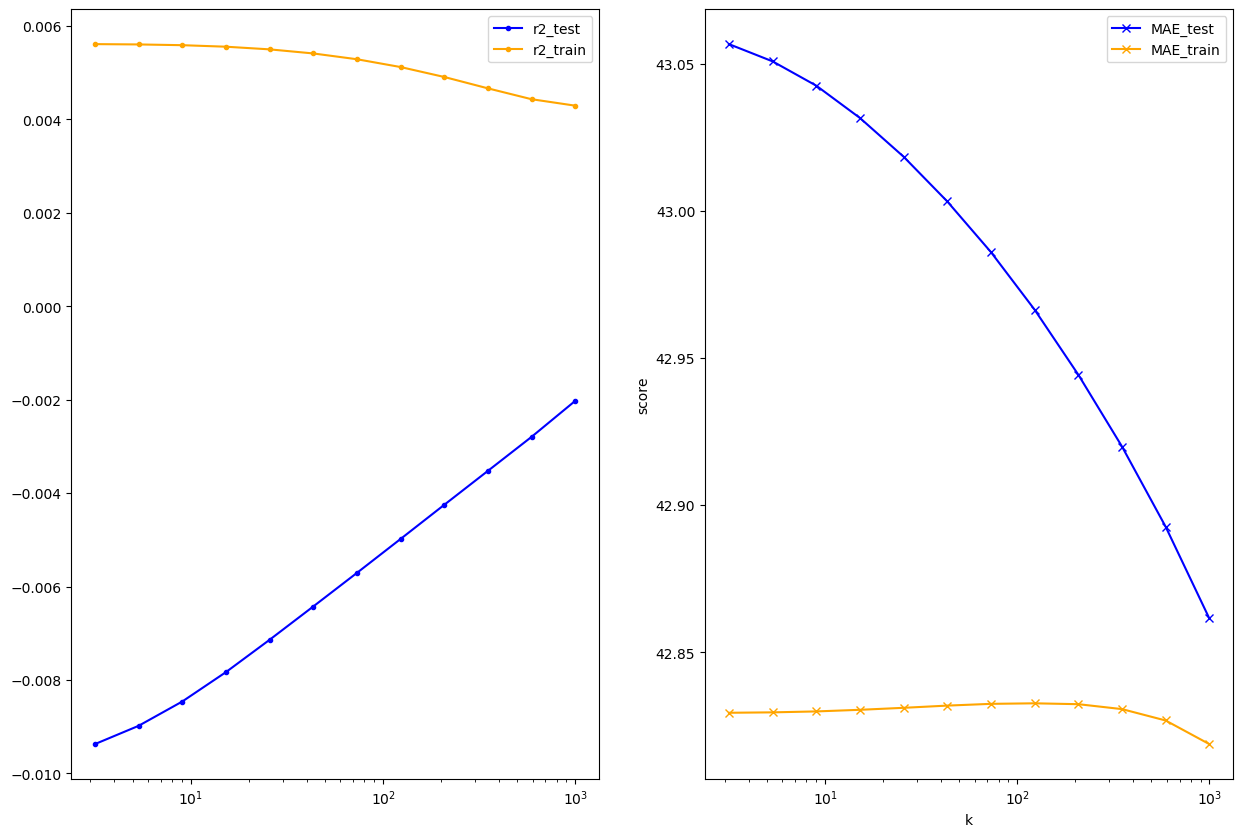

In [103]:
# k
vals = np.logspace(0.5,3,num=12)
r2_test = []
r2_train = []
MAE_test = []
MAE_train = []
for x in vals:
    reg = M5regressor(smoothing=True, n_attr_leaf=500, max_depth=6,k=x,pruning=True,optimize_models=True,incremental_fit=True).fit(X_train, y_train[:,None])
    r2_test.append(r2_score(test_target, reg.predict(test)))
    r2_train.append(r2_score(train_target, reg.predict(train)))
    MAE_test.append(mean_absolute_error(test_target, reg.predict(test)))
    MAE_train.append(mean_absolute_error(train_target, reg.predict(train)))
plt.clf()
fig, ax = plt.subplots(1,2, figsize = (15,10))
ax[0].semilogx(vals, r2_test, marker='.', color="blue", label="r2_test")
ax[0].semilogx(vals, r2_train, marker='.', color="orange", label="r2_train")
ax[1].semilogx(vals, MAE_test, marker='x', color="blue", label="MAE_test")
ax[1].semilogx(vals, MAE_train, marker='x', color="orange", label="MAE_train")
ax[0].legend()
ax[1].legend()
plt.xlabel("k")
plt.ylabel("score")
print(r2_test)
plt.savefig("../figures/airquality/k_M5.jpeg")


We will take k=1000

calc split of 271661 points
dim, split 3 0.5652173913043478
calc split of 146475 points
dim, split 2 0.3
calc split of 44445 points
dim, split 4 0.20975609756097563
calc split of 657 points
dim, split 0 0.75
calc split of 439 points
dim, split 3 0.30434782608695654
calc split of 275 points
dim, split 3 0.13043478260869565
calc split of 82 points
dim, split 4 0.1951219512195122
calc split of 193 points
dim, split 6 0.26344827586206887
calc split of 164 points
dim, split 4 0.1934959349593496
calc split of 97 points
dim, split 6 0.37931034482758613
calc split of 67 points
dim, split 8 0.046511627906976744
calc split of 218 points
dim, split 4 0.1869918699186992
calc split of 108 points
dim, split 2 0.13333333333333333
calc split of 47 points
dim, split 4 0.1658536585365854
calc split of 61 points
dim, split 5 0.6076158940397356
calc split of 110 points
dim, split 3 0.34782608695652173
calc split of 103 points
dim, split 2 0.03333333333333333
calc split of 7 points
calc split of 43788 poin

dim, split 6 0.2551724137931034
calc split of 8 points
calc split of 85746 points
dim, split 5 0.7500000000000036
calc split of 125186 points
dim, split 6 0.9710344827586206
calc split of 125047 points
dim, split 1 0.36363636363636365
calc split of 41404 points
dim, split 5 0.796357615894042
calc split of 40045 points
dim, split 7 0.0027586206896551726
calc split of 39553 points
dim, split 2 0.1
calc split of 4093 points
dim, split 6 0.6799999999999999
calc split of 35460 points
dim, split 3 0.9130434782608695
calc split of 492 points
dim, split 4 0.2878048780487805
calc split of 49 points
dim, split 5 0.6539735099337776
calc split of 443 points
dim, split 3 0.6521739130434783
calc split of 1359 points
dim, split 0 0.25
calc split of 22 points
dim, split 4 0.33658536585365856
calc split of 10 points
calc split of 12 points
calc split of 1337 points
dim, split 5 0.9701986754966896
calc split of 1264 points
dim, split 6 0.27862068965517234
calc split of 73 points
dim, split 5 0.976821192

<Figure size 432x288 with 0 Axes>

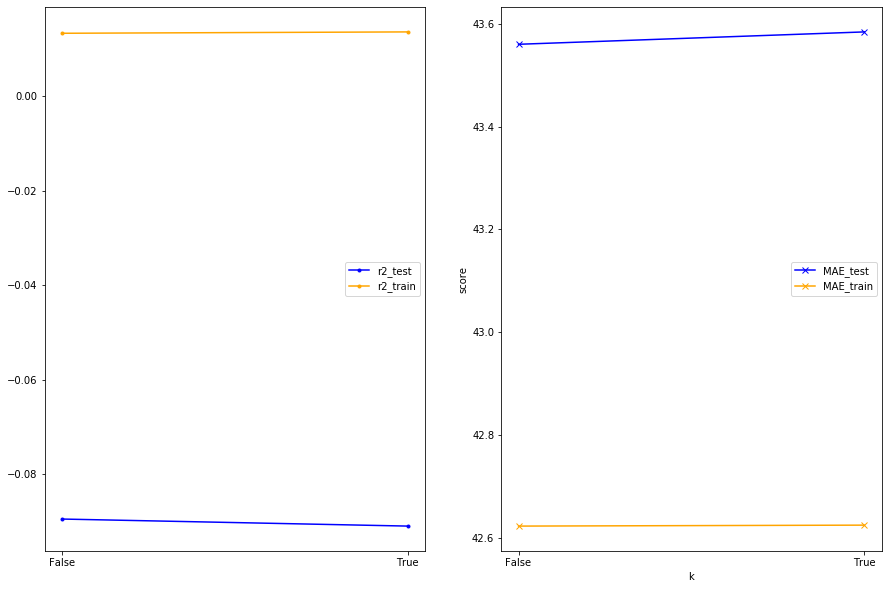

In [20]:
# optimize models
vals = [False,True]
vals_plot=["False","True"]
r2_test = []
r2_train = []
MAE_test = []
MAE_train = []
for x in vals:
    reg = M5regressor(smoothing=True, n_attr_leaf=500, max_depth=6,k=1000,pruning=True,optimize_models=x,incremental_fit=True).fit(X_train, y_train[:,None])
    r2_test.append(r2_score(test_target, reg.predict(test)))
    r2_train.append(r2_score(train_target, reg.predict(train)))
    MAE_test.append(mean_absolute_error(test_target, reg.predict(test)))
    MAE_train.append(mean_absolute_error(train_target, reg.predict(train)))
plt.clf()
fig, ax = plt.subplots(1,2, figsize = (15,10))
ax[0].plot(vals_plot, r2_test, marker='.', color="blue", label="r2_test")
ax[0].plot(vals_plot, r2_train, marker='.', color="orange", label="r2_train")
ax[1].plot(vals_plot, MAE_test, marker='x', color="blue", label="MAE_test")
ax[1].plot(vals_plot, MAE_train, marker='x', color="orange", label="MAE_train")
ax[0].legend()
ax[1].legend()
plt.xlabel("k")
plt.ylabel("score")
print(r2_test)
plt.savefig("../figures/airquality/opti_model_M5.jpeg")

There is no real difference so we will still optimize models.

calc split of 271661 points
dim, split 3 0.5652173913043478
calc split of 146475 points
dim, split 2 0.3
calc split of 44445 points
dim, split 4 0.20975609756097563
calc split of 657 points
dim, split 0 0.75
calc split of 439 points
dim, split 3 0.30434782608695654
calc split of 275 points
dim, split 3 0.13043478260869565
calc split of 82 points
dim, split 4 0.1951219512195122
calc split of 193 points
dim, split 6 0.26344827586206887
calc split of 164 points
dim, split 4 0.1934959349593496
calc split of 97 points
dim, split 6 0.37931034482758613
calc split of 67 points
dim, split 8 0.046511627906976744
calc split of 218 points
dim, split 4 0.1869918699186992
calc split of 108 points
dim, split 2 0.13333333333333333
calc split of 47 points
dim, split 4 0.1658536585365854
calc split of 61 points
dim, split 5 0.6076158940397356
calc split of 110 points
dim, split 3 0.34782608695652173
calc split of 103 points
dim, split 2 0.03333333333333333
calc split of 7 points
calc split of 43788 poin

dim, split 6 0.2551724137931034
calc split of 8 points
calc split of 85746 points
dim, split 5 0.7500000000000036
calc split of 125186 points
dim, split 6 0.9710344827586206
calc split of 125047 points
dim, split 1 0.36363636363636365
calc split of 41404 points
dim, split 5 0.796357615894042
calc split of 40045 points
dim, split 7 0.0027586206896551726
calc split of 39553 points
dim, split 2 0.1
calc split of 4093 points
dim, split 6 0.6799999999999999
calc split of 35460 points
dim, split 3 0.9130434782608695
calc split of 492 points
dim, split 4 0.2878048780487805
calc split of 49 points
dim, split 5 0.6539735099337776
calc split of 443 points
dim, split 3 0.6521739130434783
calc split of 1359 points
dim, split 0 0.25
calc split of 22 points
dim, split 4 0.33658536585365856
calc split of 10 points
calc split of 12 points
calc split of 1337 points
dim, split 5 0.9701986754966896
calc split of 1264 points
dim, split 6 0.27862068965517234
calc split of 73 points
dim, split 5 0.976821192

<Figure size 432x288 with 0 Axes>

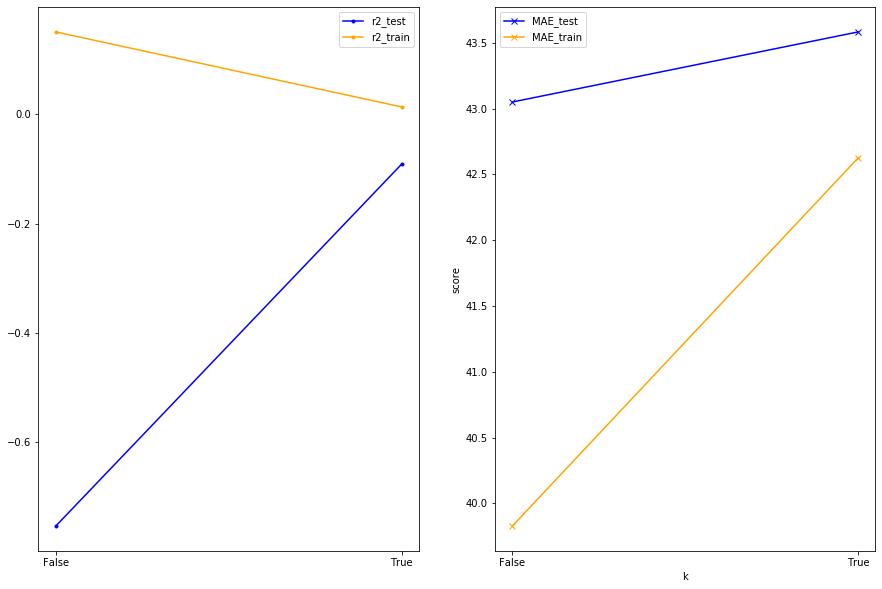

In [21]:
# incremental fit
vals = [False,True]
vals_plot=["False","True"]
r2_test = []
r2_train = []
MAE_test = []
MAE_train = []
for x in vals:
    reg = M5regressor(smoothing=True, n_attr_leaf=500, max_depth=6,k=1000,pruning=True,optimize_models=True,incremental_fit=x).fit(X_train, y_train[:,None])
    r2_test.append(r2_score(test_target, reg.predict(test)))
    r2_train.append(r2_score(train_target, reg.predict(train)))
    MAE_test.append(mean_absolute_error(test_target, reg.predict(test)))
    MAE_train.append(mean_absolute_error(train_target, reg.predict(train)))
plt.clf()
fig, ax = plt.subplots(1,2, figsize = (15,10))
ax[0].plot(vals_plot, r2_test, marker='.', color="blue", label="r2_test")
ax[0].plot(vals_plot, r2_train, marker='.', color="orange", label="r2_train")
ax[1].plot(vals_plot, MAE_test, marker='x', color="blue", label="MAE_test")
ax[1].plot(vals_plot, MAE_train, marker='x', color="orange", label="MAE_train")
ax[0].legend()
ax[1].legend()
plt.xlabel("k")
plt.ylabel("score")
print(r2_test)
plt.savefig("../figures/airquality/incr_fit_M5.jpeg")

We need incremental fit to avoid overfitting.

# Compare with existing algorithms

We can notice that the difference can be ignored, so we will just delete the samples with missing data during the preprocessing phase.

In [104]:
import timeit

kf = KFold(n_splits=10, shuffle=True, random_state=42)
split = kf.split(df_origin)
M5regressor_r2_model, const_regressor_r2, const_regressor_sklearn_r2_model, linear_regressor_r2, random_forest_regressor_r2, extra_tree_r2, linear_tree_r2 = [], [], [], [], [], [], []
M5regressor_MAE_model, const_regressor_MAE, const_regressor_sklearn_MAE_model, linear_regressor_MAE, random_forest_regressor_MAE, extra_tree_MAE, linear_tree_MAE = [], [], [], [], [], [], []
times = {"M5":-1, "cons":-1, "cons_sk":-1, "linear":-1, "random_forest":-1, "extratree":-1, "linear_tree":-1}

# We split the data and apply the pre-processing

for train_index, test_index in split:
    
        train_set = preprocessing_mean(df_origin.iloc[train_index])
        test_set = preprocessing_mean(df_origin.iloc[test_index])
        y_train = trains[i][:,indO3]
        y_test = tests[i][:,indO3]
        X_train = np.delete(trains[i], indO3, axis=1)
        X_test = np.delete(tests[i], indO3, axis=1)

        #M5 regressor tree own
        start = timeit.default_timer()
        reg = M5regressor(smoothing=True, n_attr_leaf=500, max_depth=6,k=1000,pruning=True,optimize_models=True,incremental_fit=True).fit(X_train, y_train[:,None])
        M5regressor_r2_model.append(r2_score(y_test, reg.predict(X_test)))
        M5regressor_MAE_model.append(mean_absolute_error(y_test, reg.predict(X_test)))
        times["M5"] = timeit.default_timer()-start
        
        #Constant regressor tree own
        start = timeit.default_timer()
        reg2 = Const_regressor(n_attr_leaf = 300, max_depth=8).fit(X_train, y_train[:,None])
        const_regressor_r2.append(r2_score(y_test, reg2.predict(X_test)))
        const_regressor_MAE.append(mean_absolute_error(y_test, reg2.predict(X_test)))
        times["cons"] = timeit.default_timer()-start
        
        #Constant regressor tree SKlearn #SAME PARAMETERS AS OURS?
        start = timeit.default_timer()
        const_regressor_sklearn = tree.DecisionTreeRegressor(min_samples_leaf=4, max_depth=8, random_state=42).fit(X_train, y_train)
        const_regressor_sklearn_r2_model.append(r2_score(y_test, const_regressor_sklearn.predict(X_test)))
        const_regressor_sklearn_MAE_model.append(mean_absolute_error(y_test, const_regressor_sklearn.predict(X_test)))
        times["cons_sk"] = timeit.default_timer()-start
        #Linear regression sklearn
        start = timeit.default_timer()
        linear_regressor = LinearRegression().fit(X_train, y_train)
        linear_regressor_r2.append(r2_score(y_test, linear_regressor.predict(X_test)))
        linear_regressor_MAE.append(mean_absolute_error(y_test, linear_regressor.predict(X_test)))
        times["linear"] = timeit.default_timer()-start
        # Random forrest regressor
        start = timeit.default_timer()
        random_forest_regressor = RandomForestRegressor(max_depth=8, min_samples_split=4, random_state=42).fit(X_train, y_train)
        random_forest_regressor_r2.append(r2_score(y_test, random_forest_regressor.predict(X_test)))
        random_forest_regressor_MAE.append(mean_absolute_error(y_test, random_forest_regressor.predict(X_test)))
        times["random_forest"] = timeit.default_timer()-start
        #Extra tree regressor
        start = timeit.default_timer()
        extra_tree_regressor = ExtraTreeRegressor(max_depth=8, random_state=42).fit(X_train, y_train)
        extra_tree_r2.append(r2_score(y_test, extra_tree_regressor .predict(X_test)))
        extra_tree_MAE.append(mean_absolute_error(y_test, extra_tree_regressor .predict(X_test)))
        times["extratree"] = timeit.default_timer()-start
        # linear tree (model tree from Gitbhub)
        start = timeit.default_timer()
        linear_tree_regressor = LinearTreeRegressor(max_depth=8, min_samples_split= 6, base_estimator=LinearRegression()).fit(X_train, y_train)  # supports also multi-target and sample_weights
        linear_tree_r2.append(r2_score(y_test, linear_tree_regressor.predict(X_test)))
        linear_tree_MAE.append(mean_absolute_error(y_test, linear_tree_regressor.predict(X_test)))
        times["linear_tree"] = timeit.default_timer()-start


m5_r2 = np.mean(M5regressor_r2_model)
cons_r2 = np.mean(const_regressor_r2)                                           
cons_sklearn_r2 = np.mean(const_regressor_sklearn_r2_model)   
linear_r2 = np.mean(linear_regressor_r2)
random_r2 =np.mean(random_forest_regressor_r2)
extra_r2= np.mean(extra_tree_r2)
lintree_r2 = np.mean(linear_tree_r2)
m5_MAE = np.mean(M5regressor_MAE_model)
cons_MAE = np.mean(const_regressor_MAE)                                           
cons_sklearn_MAE = np.mean(const_regressor_sklearn_MAE_model)   
linear_MAE = np.mean(linear_regressor_MAE)
random_MAE =np.mean(random_forest_regressor_MAE)
extra_MAE = np.mean(extra_tree_MAE)
lintree_MAE = np.mean(linear_tree_MAE)
print("m5 r2", m5_r2, "MAE", m5_MAE )
print("cons r2",cons_r2, "MAE", cons_MAE  )
print("cons_sklearn r2", cons_sklearn_r2, "MAE", cons_sklearn_MAE) 
print("linear r2", linear_r2, "MAE", linear_MAE)
print("random r2", random_r2, "MAE", random_MAE)
print("extra r2", extra_r2, "MAE", extra_MAE)
print("linear tree", lintree_r2, "MAE", lintree_MAE)
print(times)

calc split of 271661 points
dim, split 5 0.06953642384106118
calc split of 271439 points
dim, split 8 0.8106060606060606
calc split of 271414 points
dim, split 1 0.09090909090909091
calc split of 23314 points
dim, split 5 0.49172185430463955
calc split of 2032 points
dim, split 3 0.6956521739130435
calc split of 1461 points
dim, split 3 0.5652173913043478
calc split of 1149 points
dim, split 6 0.529655172413793
calc split of 571 points
dim, split 3 0.8695652173913043
calc split of 21282 points
dim, split 5 0.5066225165562948
calc split of 21090 points
dim, split 4 0.32218597063621535
calc split of 14904 points
dim, split 3 0.2608695652173913
calc split of 6186 points
dim, split 3 0.8695652173913043
calc split of 248100 points
dim, split 5 0.2350993377483448
calc split of 23101 points
dim, split 5 0.19867549668874318
calc split of 12119 points
dim, split 6 0.9668965517241379
calc split of 11987 points
dim, split 6 0.9503448275862068
calc split of 10982 points
dim, split 4 0.634584013050

calc split of 224999 points
calc split of 224572 points
calc split of 223539 points
calc split of 47000 points
calc split of 2786 points
calc split of 44214 points
calc split of 176539 points
calc split of 173152 points
calc split of 3387 points
calc split of 1033 points
calc split of 881 points
calc split of 454 points
calc split of 427 points
calc split of 427 points
calc split of 271661 points
dim, split 5 0.06953642384106118
calc split of 271439 points
dim, split 8 0.8106060606060606
calc split of 271414 points
dim, split 1 0.09090909090909091
calc split of 23314 points
dim, split 5 0.49172185430463955
calc split of 2032 points
dim, split 3 0.6956521739130435
calc split of 1461 points
dim, split 3 0.5652173913043478
calc split of 1149 points
dim, split 6 0.529655172413793
calc split of 571 points
dim, split 3 0.8695652173913043
calc split of 21282 points
dim, split 5 0.5066225165562948
calc split of 21090 points
dim, split 4 0.32218597063621535
calc split of 14904 points
dim, split

calc split of 23101 points
calc split of 12119 points
calc split of 11987 points
calc split of 11847 points
calc split of 11671 points
calc split of 10982 points
calc split of 1291 points
calc split of 1269 points
calc split of 1171 points
calc split of 9691 points
calc split of 995 points
calc split of 727 points
calc split of 8696 points
calc split of 2760 points
calc split of 5936 points
calc split of 224999 points
calc split of 224572 points
calc split of 223539 points
calc split of 47000 points
calc split of 2786 points
calc split of 44214 points
calc split of 176539 points
calc split of 173152 points
calc split of 3387 points
calc split of 1033 points
calc split of 881 points
calc split of 454 points
calc split of 427 points
calc split of 427 points
calc split of 271661 points
dim, split 5 0.06953642384106118
calc split of 271439 points
dim, split 8 0.8106060606060606
calc split of 271414 points
dim, split 1 0.09090909090909091
calc split of 23314 points
dim, split 5 0.4917218543

calc split of 14904 points
calc split of 4671 points
calc split of 4013 points
calc split of 658 points
calc split of 10233 points
calc split of 8924 points
calc split of 1309 points
calc split of 6186 points
calc split of 5469 points
calc split of 5214 points
calc split of 717 points
calc split of 707 points
calc split of 248100 points
calc split of 23101 points
calc split of 12119 points
calc split of 11987 points
calc split of 11847 points
calc split of 11671 points
calc split of 10982 points
calc split of 1291 points
calc split of 1269 points
calc split of 1171 points
calc split of 9691 points
calc split of 995 points
calc split of 727 points
calc split of 8696 points
calc split of 2760 points
calc split of 5936 points
calc split of 224999 points
calc split of 224572 points
calc split of 223539 points
calc split of 47000 points
calc split of 2786 points
calc split of 44214 points
calc split of 176539 points
calc split of 173152 points
calc split of 3387 points
calc split of 1033 po

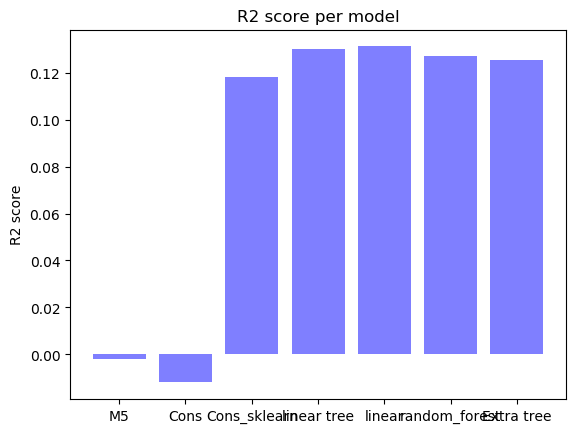

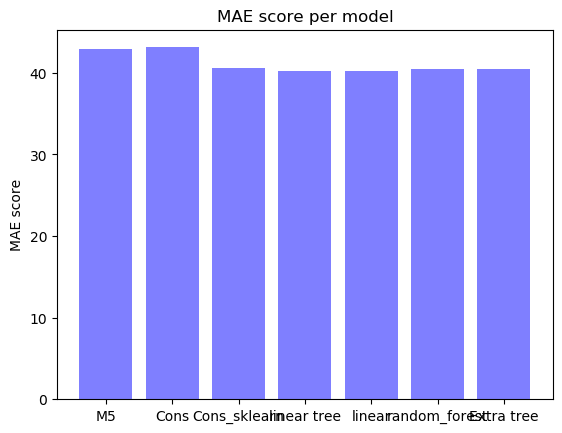

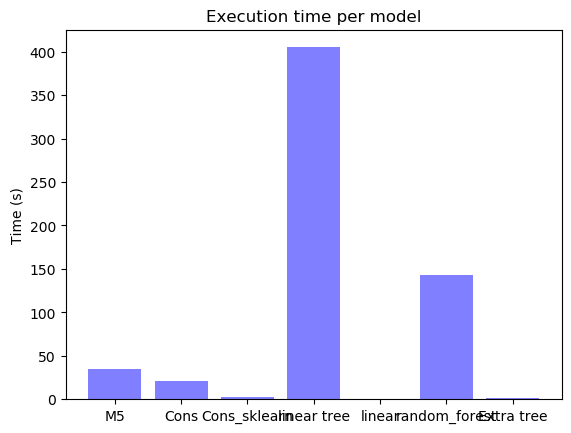

In [105]:
objects = ('M5', 'Cons', 'Cons_sklearn', 'linear tree', 'linear', 'random_forest', 'Extra tree')
y_pos = np.arange(len(objects))
r2score = [m5_r2,cons_r2,cons_sklearn_r2,lintree_r2,linear_r2,random_r2,extra_r2]

plt.bar(y_pos, r2score, align='center', alpha=0.5, color='blue')
plt.xticks(y_pos, objects)
plt.ylabel('R2 score')
plt.title('R2 score per model')
plt.savefig("../figures/airquality/r2scores.jpeg")
plt.show()

objects = ('M5', 'Cons', 'Cons_sklearn', 'linear tree', 'linear', 'random_forest', 'Extra tree')
y_pos = np.arange(len(objects))
MAEscore = [m5_MAE,cons_MAE,cons_sklearn_MAE, lintree_MAE, linear_MAE,random_MAE,extra_MAE]

plt.bar(y_pos, MAEscore, align='center', alpha=0.5, color='blue')
plt.xticks(y_pos, objects)
plt.ylabel('MAE score')
plt.title('MAE score per model')
plt.savefig("../figures/airquality/MAEscores.jpeg")
plt.show()

objects = ('M5', 'Cons', 'Cons_sklearn', 'linear tree', 'linear', 'random_forest', 'Extra tree')
y_pos = np.arange(len(objects))
Y = [times['M5'], times['cons'], times['cons_sk'], times['linear_tree'], times['linear'], times['random_forest'], times['extratree']]
plt.bar(y_pos, Y, align='center', alpha=0.5, color='blue')
plt.xticks(y_pos, objects)
plt.ylabel('Time (s)')
plt.title('Execution time per model')
plt.savefig("../figures/airquality/Execution time per model.jpeg")
plt.show()